In [2]:
import os 
import copy
import pandas as pd 
import numpy as np 
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
import umap 

from statsmodels.stats.multitest import multipletests


import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packag

In [304]:
base_dir =  "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score"
year = "after1y"

HarvardOxford_cort_attr_save_dir = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
HarvardOxford_subcort_attr_save_dir = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
cerebellum_attr_save_dir = os.path.join(*[base_dir, year, "Cerebellum-MNIfnirt-maxprob-thr25-1mm_MeanAttrScore.csv"])
ReinforcementLearning_attr_save_dir = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
Amygdala_attr_save_dir = os.path.join(*[base_dir, year, "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])
merged_attr_save_dir = os.path.join(*[base_dir, year, "merged.csv"])

if year == 'after1y':
    phenotype_dir  = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/ABCD_phenotype_total_1years_become_overweight_10PS_stratified_partitioned_5fold.csv'
elif year == 'after2y': 
    phenotype_dir  = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/ABCD_phenotype_total_2years_become_overweight_10PS_stratified_partitioned_5fold.csv'

all = False 
data = Amygdala_attr_save_dir

In [305]:
# loading data
if all: 
    attr_list = [HarvardOxford_cort_attr_save_dir, HarvardOxford_subcort_attr_save_dir, cerebellum_attr_save_dir, ReinforcementLearning_attr_save_dir, Amygdala_attr_save_dir, merged_attr_save_dir]
    for i, attr in enumerate(attr_list): 
        if i == 0: 
            attr_score = pd.read_csv(attr_list[i])
        else: 
            attr_score_tmp = pd.read_csv(attr_list[i])
            attr_score = pd.merge(attr_score, attr_score_tmp,how='inner', on='subjectkey')
else:
    attr_score = pd.read_csv(data)

# filtering case subject 
pheno = pd.read_csv(phenotype_dir)
case_subject_list = list(pheno[pheno['become_overweight'] == 1]['subjectkey'].values)
case_subject_list = pd.DataFrame({'subjectkey': case_subject_list})
attr_score_filtered = pd.merge(attr_score, case_subject_list, how='inner', on='subjectkey')

# filtering out subjectkey and zero values
for k in attr_score_filtered.keys(): 
    if k == 'subjectkey':
        attr_score_filtered = attr_score_filtered.drop('subjectkey', axis=1, inplace=False)
    else: 
        if np.sum(attr_score_filtered[k].values) == 0: 
            attr_score_filtered = attr_score_filtered.drop(k, axis=1, inplace=False)
X = attr_score_filtered.values 

### correlation plot of raw data (visusal check)

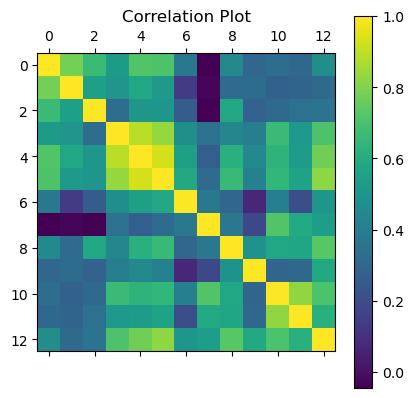

In [812]:
plt.matshow(attr_score_filtered.corr())
plt.colorbar()
plt.title("Correlation Plot")
plt.show()


### UMAP

Text(0.5, 1.0, 'UMAP')

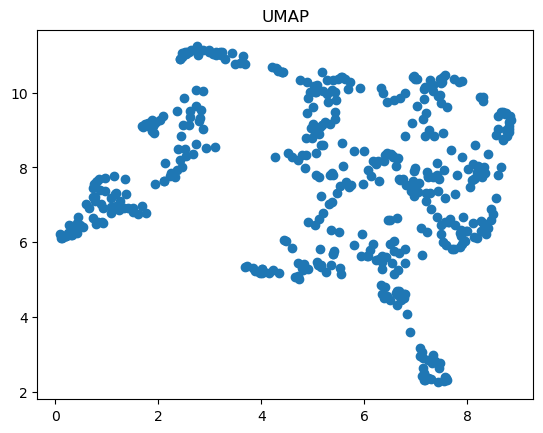

In [813]:
scaler = StandardScaler() 
reducer = umap.UMAP() 

scaled_X = scaler.fit_transform(X)
embedding = reducer.fit_transform(scaled_X)
plt.scatter(embedding[:,0], embedding[:,1])
plt.title("UMAP")

### TSNE

Text(0.5, 1.0, 't-SNE')

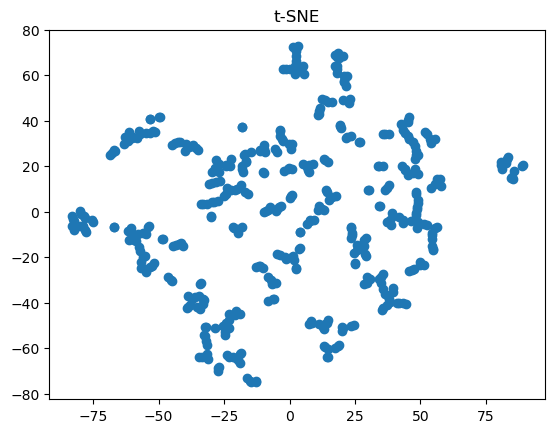

In [814]:
from sklearn.manifold import TSNE 
scaler = StandardScaler() 
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
scaled_X = scaler.fit_transform(X)
embedding = tsne.fit_transform(scaled_X)
plt.scatter(embedding[:,0], embedding[:,1])
plt.title("t-SNE")

### K-means clustering

For n_clusters = 2 The average silhouette_score is : 0.4790475446008076
For n_clusters = 3 The average silhouette_score is : 0.2666404672891214
For n_clusters = 4 The average silhouette_score is : 0.25398293993353405
For n_clusters = 5 The average silhouette_score is : 0.21521502344481733
For n_clusters = 6 The average silhouette_score is : 0.21419036045414566


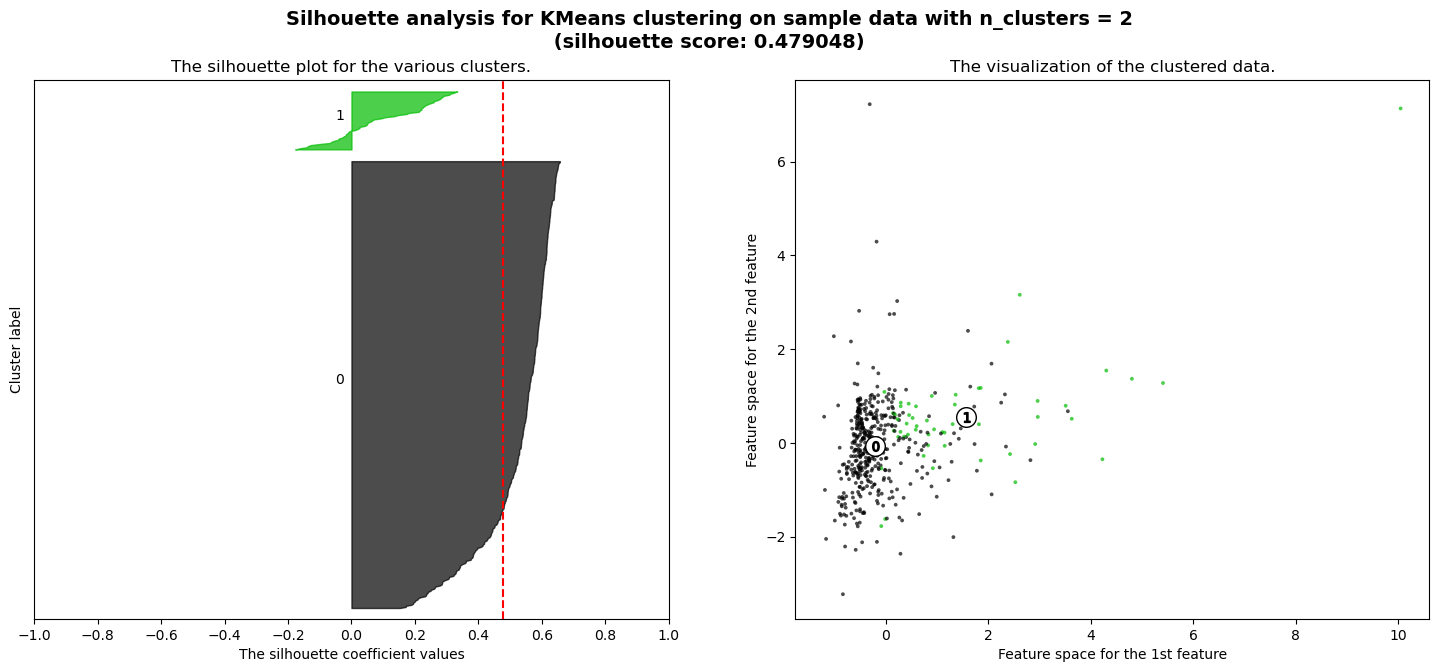

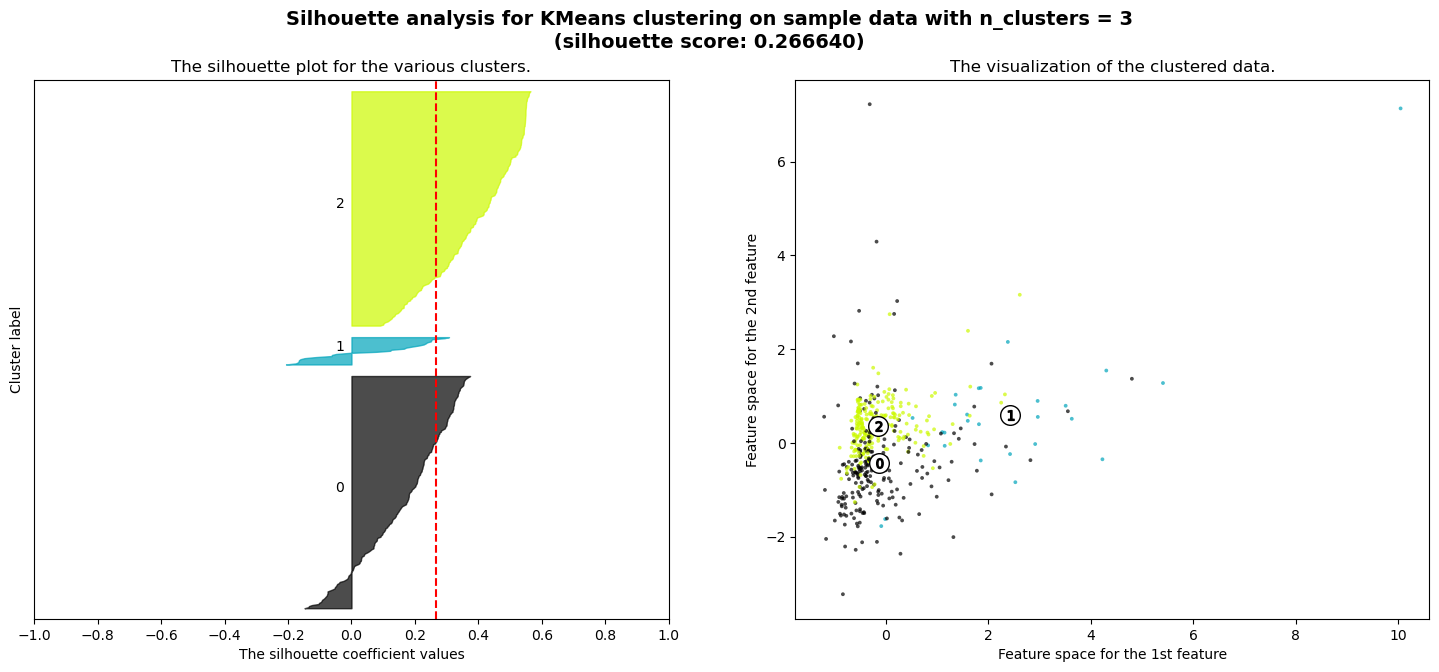

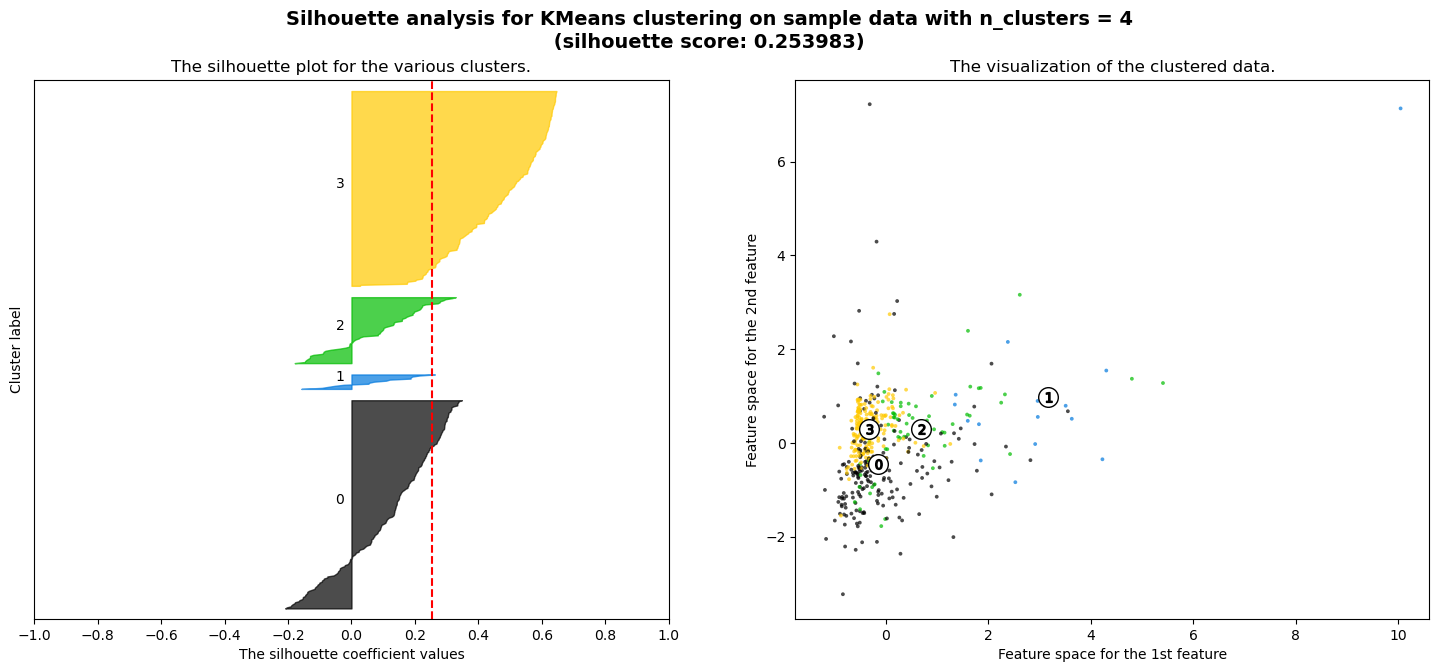

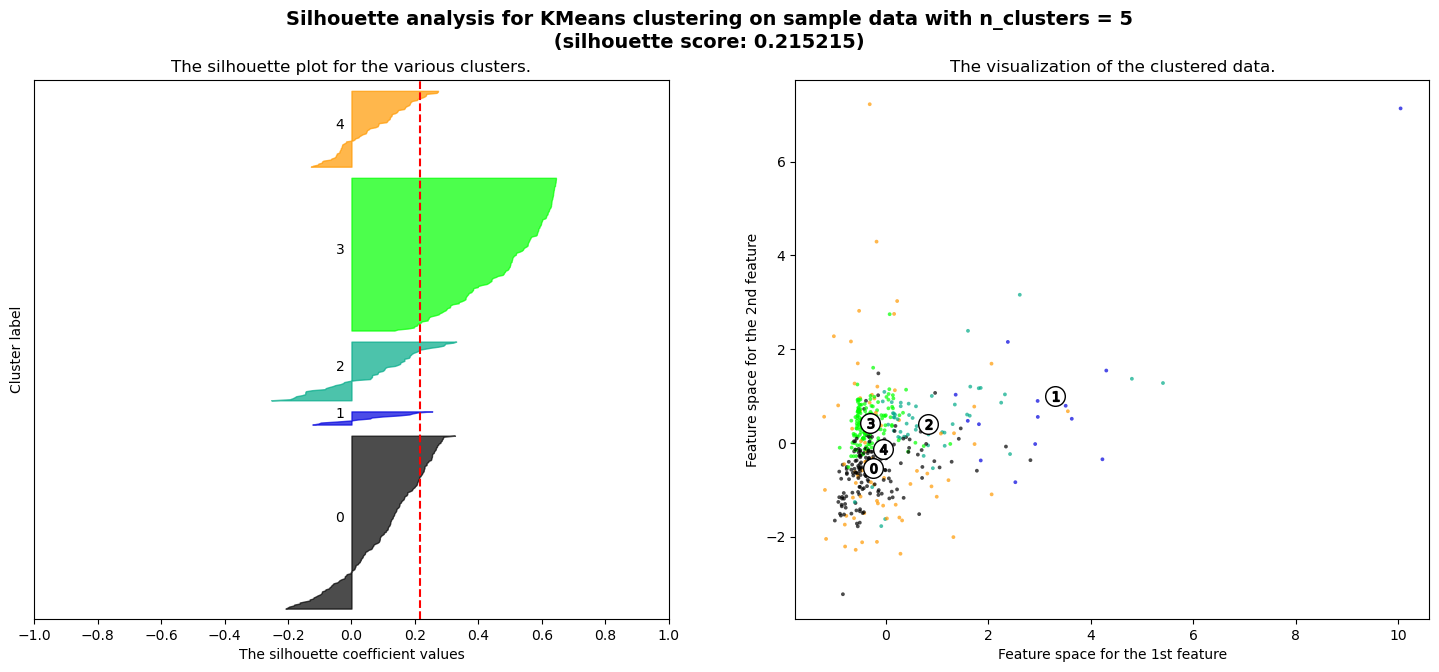

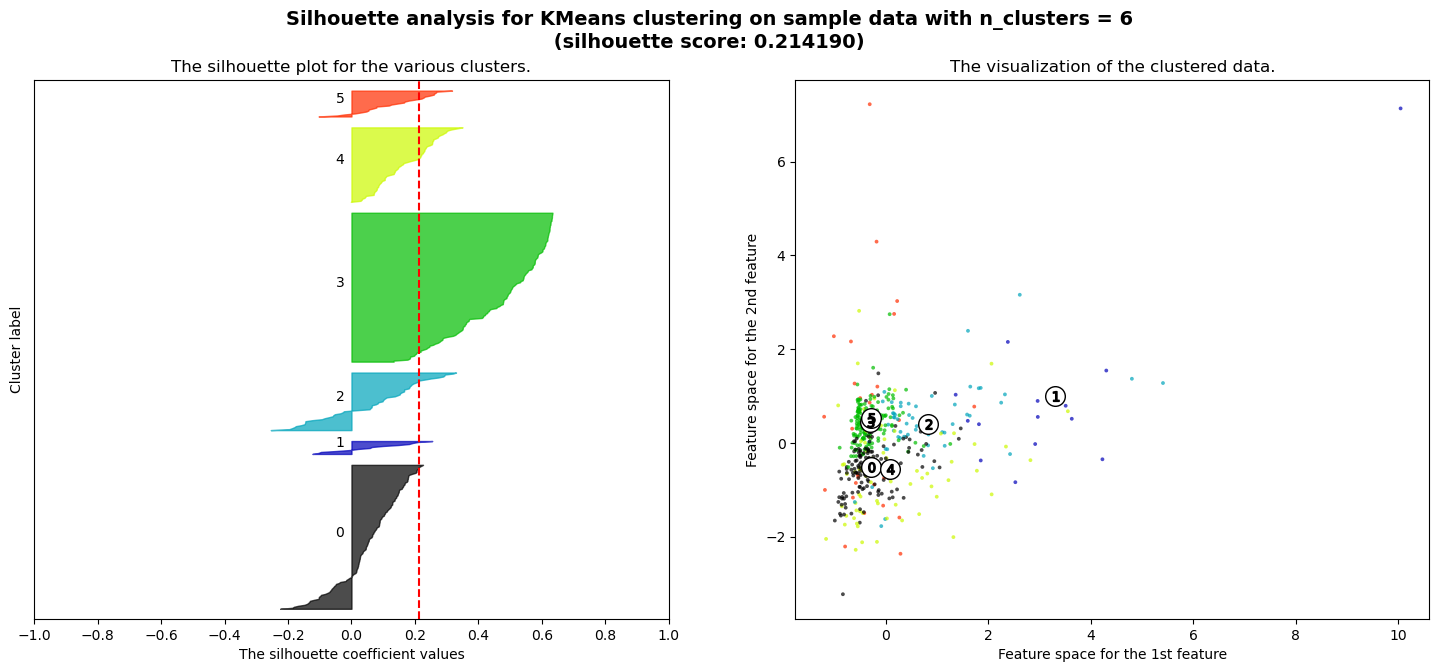

In [293]:
scaler = StandardScaler() 
scaled_X = scaler.fit_transform(X)

range_n_clusters = [2,3,4,5,6]

for n_clusters in range_n_clusters: 
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(scaled_X)+(n_clusters+1)*10])

    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=0)
    cluster_labels = kmeans.fit_predict(scaled_X)

    silhouette_avg = silhouette_score(scaled_X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    sample_silhouette_values = silhouette_samples(scaled_X, cluster_labels)

    y_lower = 10 
    for i in range(n_clusters): 
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])


    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        scaled_X[:, 0], scaled_X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = {}\n (silhouette score: {:2f}) ".format(n_clusters, silhouette_avg),
        fontsize=14,
        fontweight="bold",
    )

### Heirarchical clustering

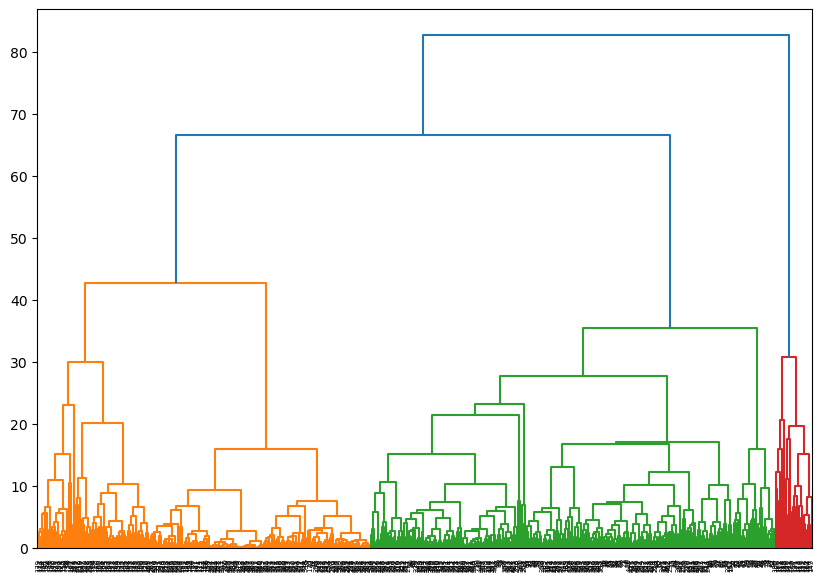

In [294]:
from scipy.cluster.hierarchy import dendrogram, linkage 
from scipy.cluster.hierarchy import fcluster 

scaler = StandardScaler() 
scaled_X = scaler.fit_transform(X)

linked = linkage(scaled_X, 'ward')
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

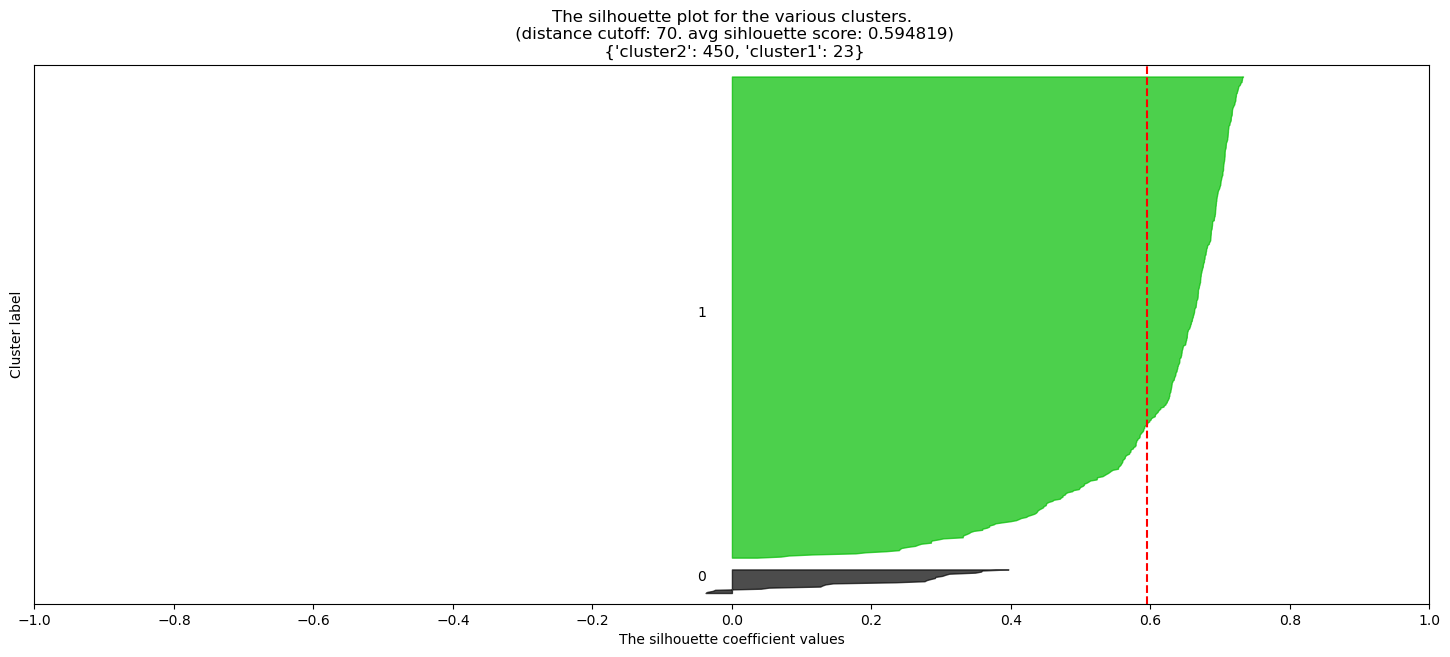

In [299]:
cutoff = 70

predict = pd.DataFrame(fcluster(linked, cutoff, criterion='distance'))
predict.columns = ['predict']
n_clusters = len(pd.value_counts(predict['predict']).index)

# plotting result
fig, ax1  = plt.subplots(1,1)
fig.set_size_inches(18, 7)

ax1.set_xlim([-1, 1])
ax1.set_ylim([0, len(scaled_X)+(n_clusters+1)*10])

silhouette_avg = silhouette_score(scaled_X, predict['predict'].values)
sample_silhouette_values = silhouette_samples(scaled_X, predict['predict'].values)

y_lower = 10 
for i in range(n_clusters): 
    ith_cluster_silhouette_values = sample_silhouette_values[predict['predict'].values == i + 1]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10 
# summarizing    
subject_per_label = {} 
for i, k in enumerate(pd.value_counts(predict['predict']).index): 
    subject_per_label['cluster%s' % str(k)] = pd.value_counts(predict['predict']).values[i]
ax1.set_title("The silhouette plot for the various clusters.\n (distance cutoff: {}. avg sihlouette score: {:2f})\n {}".format(cutoff, silhouette_avg,subject_per_label))
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])



## significant result

In [3]:
def clustering_KMEANS(base_dir, save_dir, cluster_save_dir, year, data, n_clusters, scaler):
    if data.find('HarvardOxford-cort'):
        save_dir = os.path.join(save_dir, 'HarvardOxford_Cortical')
    elif data.find('HarvardOxford-sub'):
        save_dir = os.path.join(save_dir, 'HarvardOxford_Subcortical')
    elif data.find('Cerebellum'):
        save_dir = os.path.join(save_dir, 'Cerebellum')
    elif data.find('CIT168toMNI152-FSL'):
        save_dir = os.path.join(save_dir, 'ReinforcementLearning')
    elif data.find('CIT168_iAmyNuc'):
        save_dir = os.path.join(save_dir, 'Amygdala')

    # filtering case subject 
    if year == 'after1y':
        phenotype_dir  = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/ABCD_phenotype_total_1years_become_overweight_10PS_stratified_partitioned_5fold.csv'
    elif year == 'after2y': 
        phenotype_dir  = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/ABCD_phenotype_total_2years_become_overweight_10PS_stratified_partitioned_5fold.csv'
    pheno = pd.read_csv(phenotype_dir)
    case_subject_list = list(pheno[pheno['become_overweight'] == 1]['subjectkey'].values)
    case_subject_list = pd.DataFrame({'subjectkey': case_subject_list})
    control_subject_list = list(pheno[pheno['become_overweight'] == 0]['subjectkey'].values)
    control_subject_list = pd.DataFrame({'subjectkey': control_subject_list})
    attr_score_case = pd.merge(attr_score, case_subject_list, how='inner', on='subjectkey')
    # fitering case subject for delta 
    pheno_delta = pd.read_csv('/Users/wangheehwan/Desktop/CNN_for_BMI/phenotype_data/ABCD Release4.0 Tabular dataset.csv')
    for i in range(len(pheno_delta)): 
        pheno_delta['subjectkey'][i] = pheno_delta['subjectkey'][i].replace('_','')
    pheno_delta_filtered = pd.merge(pheno_delta, case_subject_list, how='inner', on='subjectkey')

    # filtering out subjectkey and zero values
    for k in attr_score_case.keys(): 
        if k == 'subjectkey':
            attr_score_case = attr_score_case.drop('subjectkey', axis=1, inplace=False)
        else: 
            if np.sum(attr_score_case[k].values) == 0: 
                attr_score_case = attr_score_case.drop(k, axis=1, inplace=False)
    X = attr_score_case.values 
    scaled_X = scaler.fit_transform(X)


    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=0)
    cluster_labels = kmeans.fit_predict(scaled_X)
    print(silhouette_score(scaled_X, cluster_labels))
    cluster_label_pheno = pd.merge(attr_score, case_subject_list, how='inner', on='subjectkey')
    cluster_label_pheno['cluster_label'] = cluster_labels
    pheno_cluster = pd.merge(pheno, cluster_label_pheno[['subjectkey', 'cluster_label']], how='inner', on='subjectkey')
    pheno_cluster_delta = pd.merge(pheno_delta_filtered, cluster_label_pheno[['subjectkey', 'cluster_label']], how='inner', on='subjectkey')
    pheno_control = pd.merge(pheno, control_subject_list, how='inner', on='subjectkey')
    pheno_delta_control = pd.merge(pheno_delta, control_subject_list, how='inner', on='subjectkey')


    if data.find('HarvardOxford-cort') != -1:
        cluster_save_dir = os.path.join(cluster_save_dir, 'HarvardOxford_Cortical')
        pheno_cluster.to_csv(os.path.join(cluster_save_dir, '{}_case_cluster.csv'.format(year)), index=False)
        pheno_cluster_delta.to_csv(os.path.join(cluster_save_dir, '{}_case_cluster_delta.csv'.format(year)), index=False)
        pheno_control.to_csv(os.path.join(cluster_save_dir, '{}_control_cluster.csv'.format(year)), index=False)
        pheno_delta_control.to_csv(os.path.join(cluster_save_dir, '{}_control_cluster_delta.csv'.format(year)), index=False)
    elif data.find('HarvardOxford-sub') != -1:
        cluster_save_dir = os.path.join(cluster_save_dir, 'HarvardOxford_Subcortical')
        pheno_cluster.to_csv(os.path.join(cluster_save_dir, '{}_case_cluster.csv'.format(year)), index=False)
        pheno_cluster_delta.to_csv(os.path.join(cluster_save_dir, '{}_case_cluster_delta.csv'.format(year)), index=False)
        pheno_control.to_csv(os.path.join(cluster_save_dir, '{}_control_cluster.csv'.format(year)), index=False)
        pheno_delta_control.to_csv(os.path.join(cluster_save_dir, '{}_control_cluster_delta.csv'.format(year)), index=False)
    elif data.find('Cerebellum') != -1:
        cluster_save_dir = os.path.join(cluster_save_dir, 'Cerebellum')
        pheno_cluster.to_csv(os.path.join(cluster_save_dir, '{}_case_cluster.csv'.format(year)), index=False)
        pheno_cluster_delta.to_csv(os.path.join(cluster_save_dir, '{}_case_cluster_delta.csv'.format(year)), index=False)
        pheno_control.to_csv(os.path.join(cluster_save_dir, '{}_control_cluster.csv'.format(year)), index=False)
        pheno_delta_control.to_csv(os.path.join(cluster_save_dir, '{}_control_cluster_delta.csv'.format(year)), index=False)
    elif data.find('CIT168toMNI152-FSL') != -1:
        cluster_save_dir = os.path.join(cluster_save_dir, 'ReinforcementLearning')
        pheno_cluster.to_csv(os.path.join(cluster_save_dir, '{}_case_cluster.csv'.format(year)), index=False)
        pheno_cluster_delta.to_csv(os.path.join(cluster_save_dir, '{}_case_cluster_delta.csv'.format(year)), index=False)
        pheno_control.to_csv(os.path.join(cluster_save_dir, '{}_control_cluster.csv'.format(year)), index=False)
        pheno_delta_control.to_csv(os.path.join(cluster_save_dir, '{}_control_cluster_delta.csv'.format(year)), index=False)
    elif data.find('CIT168_iAmyNuc') != -1:
        cluster_save_dir = os.path.join(cluster_save_dir, 'Amygdala')
        pheno_cluster.to_csv(os.path.join(cluster_save_dir, '{}_case_cluster.csv'.format(year)), index=False)
        pheno_cluster_delta.to_csv(os.path.join(cluster_save_dir, '{}_case_cluster_delta.csv'.format(year)), index=False)
        pheno_control.to_csv(os.path.join(cluster_save_dir, '{}_control_cluster.csv'.format(year)), index=False)
        pheno_delta_control.to_csv(os.path.join(cluster_save_dir, '{}_control_cluster_delta.csv'.format(year)), index=False)

    return pheno_cluster, pheno_cluster_delta, pheno_control, pheno_delta_control

In [4]:
def clustering_HIERARCHICAL(base_dir, save_dir, cluster_save_dir, year, data, cutoff, scaler):
    if data.find('HarvardOxford-cort'):
        save_dir = os.path.join(save_dir, 'HarvardOxford_Cortical')
    elif data.find('HarvardOxford-sub'):
        save_dir = os.path.join(save_dir, 'HarvardOxford_Subcortical')
    elif data.find('Cerebellum'):
        save_dir = os.path.join(save_dir, 'Cerebellum')
    elif data.find('CIT168toMNI152-FSL'):
        save_dir = os.path.join(save_dir, 'ReinforcementLearning')
    elif data.find('CIT168_iAmyNuc'):
        save_dir = os.path.join(save_dir, 'Amygdala')

    # filtering case subject 
    if year == 'after1y':
        phenotype_dir  = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/ABCD_phenotype_total_1years_become_overweight_10PS_stratified_partitioned_5fold.csv'
    elif year == 'after2y': 
        phenotype_dir  = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/ABCD_phenotype_total_2years_become_overweight_10PS_stratified_partitioned_5fold.csv'
    pheno = pd.read_csv(phenotype_dir)
    case_subject_list = list(pheno[pheno['become_overweight'] == 1]['subjectkey'].values)
    case_subject_list = pd.DataFrame({'subjectkey': case_subject_list})
    control_subject_list = list(pheno[pheno['become_overweight'] == 0]['subjectkey'].values)
    control_subject_list = pd.DataFrame({'subjectkey': control_subject_list})
    attr_score_case = pd.merge(attr_score, case_subject_list, how='inner', on='subjectkey')
    # fitering case subject for delta 
    pheno_delta = pd.read_csv('/Users/wangheehwan/Desktop/CNN_for_BMI/phenotype_data/ABCD Release4.0 Tabular dataset.csv')
    for i in range(len(pheno_delta)): 
        pheno_delta['subjectkey'][i] = pheno_delta['subjectkey'][i].replace('_','')
    pheno_delta_filtered = pd.merge(pheno_delta, case_subject_list, how='inner', on='subjectkey')

    # filtering out subjectkey and zero values
    for k in attr_score_case.keys(): 
        if k == 'subjectkey':
            attr_score_case = attr_score_case.drop('subjectkey', axis=1, inplace=False)
        else: 
            if np.sum(attr_score_case[k].values) == 0: 
                attr_score_case = attr_score_case.drop(k, axis=1, inplace=False)
    X = attr_score_case.values 
    scaled_X = scaler.fit_transform(X)

    linked = linkage(scaled_X, 'ward')

    print(silhouette_score(scaled_X, fcluster(linked, cutoff, criterion='distance')-1))
    cluster_label_pheno = pd.merge(attr_score, case_subject_list, how='inner', on='subjectkey')
    cluster_label_pheno['cluster_label'] = fcluster(linked, cutoff, criterion='distance')-1
    pheno_cluster = pd.merge(pheno, cluster_label_pheno[['subjectkey', 'cluster_label']], how='inner', on='subjectkey')
    pheno_cluster_delta = pd.merge(pheno_delta_filtered, cluster_label_pheno[['subjectkey', 'cluster_label']], how='inner', on='subjectkey')
    pheno_control = pd.merge(pheno, control_subject_list, how='inner', on='subjectkey')
    pheno_delta_control = pd.merge(pheno_delta, control_subject_list, how='inner', on='subjectkey')


    if data.find('HarvardOxford-cort') != -1:
        cluster_save_dir = os.path.join(cluster_save_dir, 'HarvardOxford_Cortical')
        pheno_cluster.to_csv(os.path.join(cluster_save_dir, '{}_case_cluster.csv'.format(year)), index=False)
        pheno_cluster_delta.to_csv(os.path.join(cluster_save_dir, '{}_case_cluster_delta.csv'.format(year)), index=False)
        pheno_control.to_csv(os.path.join(cluster_save_dir, '{}_control_cluster.csv'.format(year)), index=False)
        pheno_delta_control.to_csv(os.path.join(cluster_save_dir, '{}_control_cluster_delta.csv'.format(year)), index=False)
    elif data.find('HarvardOxford-sub') != -1:
        cluster_save_dir = os.path.join(cluster_save_dir, 'HarvardOxford_Subcortical')
        pheno_cluster.to_csv(os.path.join(cluster_save_dir, '{}_case_cluster.csv'.format(year)), index=False)
        pheno_cluster_delta.to_csv(os.path.join(cluster_save_dir, '{}_case_cluster_delta.csv'.format(year)), index=False)
        pheno_control.to_csv(os.path.join(cluster_save_dir, '{}_control_cluster.csv'.format(year)), index=False)
        pheno_delta_control.to_csv(os.path.join(cluster_save_dir, '{}_control_cluster_delta.csv'.format(year)), index=False)
    elif data.find('Cerebellum') != -1:
        cluster_save_dir = os.path.join(cluster_save_dir, 'Cerebellum')
        pheno_cluster.to_csv(os.path.join(cluster_save_dir, '{}_case_cluster.csv'.format(year)), index=False)
        pheno_cluster_delta.to_csv(os.path.join(cluster_save_dir, '{}_case_cluster_delta.csv'.format(year)), index=False)
        pheno_control.to_csv(os.path.join(cluster_save_dir, '{}_control_cluster.csv'.format(year)), index=False)
        pheno_delta_control.to_csv(os.path.join(cluster_save_dir, '{}_control_cluster_delta.csv'.format(year)), index=False)
    elif data.find('CIT168toMNI152-FSL') != -1:
        cluster_save_dir = os.path.join(cluster_save_dir, 'ReinforcementLearning')
        pheno_cluster.to_csv(os.path.join(cluster_save_dir, '{}_case_cluster.csv'.format(year)), index=False)
        pheno_cluster_delta.to_csv(os.path.join(cluster_save_dir, '{}_case_cluster_delta.csv'.format(year)), index=False)
        pheno_control.to_csv(os.path.join(cluster_save_dir, '{}_control_cluster.csv'.format(year)), index=False)
        pheno_delta_control.to_csv(os.path.join(cluster_save_dir, '{}_control_cluster_delta.csv'.format(year)), index=False)
    elif data.find('CIT168_iAmyNuc') != -1:
        cluster_save_dir = os.path.join(cluster_save_dir, 'Amygdala')
        pheno_cluster.to_csv(os.path.join(cluster_save_dir, '{}_case_cluster.csv'.format(year)), index=False)
        pheno_cluster_delta.to_csv(os.path.join(cluster_save_dir, '{}_case_cluster_delta.csv'.format(year)), index=False)
        pheno_control.to_csv(os.path.join(cluster_save_dir, '{}_control_cluster.csv'.format(year)), index=False)
        pheno_delta_control.to_csv(os.path.join(cluster_save_dir, '{}_control_cluster_delta.csv'.format(year)), index=False)

    return pheno_cluster, pheno_cluster_delta, pheno_control, pheno_delta_control

In [9]:
def performing_ttest(title, target_list, year, pheno_cluster, pheno_cluster_delta, pheno_control, pheno_delta_control, save_dir, delta=True):
    if year == 'after1y': 
        followup_year = "1_year_follow_up_y_arm_1"
    elif year =='after2y':
        followup_year = '2_year_follow_up_y_arm_1' # choices = ["1_year_follow_up_y_arm_1", "2_year_follow_up_y_arm_1"] 

    ### raw score
    ## summary template
    cluster0_cluster1_t = [] 
    cluster0_cluster1_p = [] 
    cluster0_cluster1_d = [] 


    for i, target in enumerate(target_list): 
        ## data preprocess
        # control 
        df_control = pheno_control[[target]] 
        df_control.dropna(axis=0, inplace=True)
        # case
        df = pheno_cluster[['cluster_label',  target]] 
        df.dropna(axis=0, inplace=True)

        ## T-test with raw score
        # case-cluster0
        # cluster0-cluster1
        result_cluster0_cluster1 = ttest_ind(df[(df['cluster_label'] == 0)][target].values, df[(df['cluster_label'] == 1)][target].values, permutations=100000)
        cluster0_cluster1_t.append(result_cluster0_cluster1.statistic)
        cluster0_cluster1_p.append(result_cluster0_cluster1.pvalue)
        t_value = result_cluster0_cluster1.statistic
        value = len(df[(df['cluster_label'] == 0)][target].values) + len(df[(df['cluster_label'] == 1)][target].values) - 2
        cluster0_cluster1_d.append(abs(t_value) / np.sqrt(value))
        print("{} Done".format(target))


    ## Summary Result 
    #_, cluster0_cluster1_p_adj, _, _ = multipletests(cluster0_cluster1_p, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)

    df_final = [] 
    for i, target in enumerate(target_list): 
        t = []
        p = [] 
        p_adj = []

        df_target = pd.DataFrame({'test': [ 'cluster0-cluster1'],
                                'variables': [target],
                                'T-statistic': [cluster0_cluster1_t[i]],
                                'Cohens d': [cluster0_cluster1_d[i]],
                                'p_value': [cluster0_cluster1_p[i]],
                                #'p_value_BONF':  [control_cluster0_p_adj[i], control_cluster1_p_adj[i], cluster0_cluster1_p_adj[i]]
                                })
        df_final.append(df_target)
    df_final = pd.concat(df_final)
    #df_final.to_csv(os.path.join(save_dir, "{}_{}_ttest.csv".format(title, year)), index=False)

    if delta:
        ### delta score
        ## summary template
        cluster0_cluster1_delta_t = [] 
        cluster0_cluster1_delta_p = [] 
        cluster0_cluster1_delta_d = [] 
            

        for i, target in enumerate(target_list): 
            ## data preprocess
            # control delta 
            df_delta_control = pheno_delta_control[['subjectkey', 'eventname', target]] 
            df_delta_control.dropna(axis=0, inplace=True)
            baseline_control = df_delta_control[df_delta_control['eventname'] == 'baseline_year_1_arm_1'][['subjectkey',  target]] 
            baseline_control.columns = ['subjectkey', '%s_baseline' % target]     # cluster_label_baseline = cluster_label_follow
            followup_control = df_delta_control[df_delta_control['eventname'] == followup_year][['subjectkey', target]] 
            followup_control.columns = ['subjectkey', '%s_followup' % target]
            df_delta_control = pd.merge(baseline_control, followup_control, how='inner', on='subjectkey')
            df_delta_control['delta'] = df_delta_control['%s_followup' % target].values - df_delta_control['%s_baseline' % target].values
            
            # case delta
            df_delta_case = pheno_cluster_delta[['subjectkey','cluster_label', 'eventname', target]] 
            df_delta_case.dropna(axis=0, inplace=True)
            baseline_case = df_delta_case[df_delta_case['eventname'] == 'baseline_year_1_arm_1'][['subjectkey','cluster_label',  target]] 
            baseline_case.columns = ['subjectkey', 'cluster_label_baseline', '%s_baseline' % target]     # cluster_label_baseline = cluster_label_follow
            followup_case = df_delta_case[df_delta_case['eventname'] == followup_year][['subjectkey','cluster_label',  target]] 
            followup_case.columns = ['subjectkey', 'cluster_label_followup', '%s_followup' % target]
            df_delta_case = pd.merge(baseline_case, followup_case, how='inner', on='subjectkey')
            df_delta_case['delta'] = df_delta_case['%s_followup' % target].values - df_delta_case['%s_baseline' % target].values
            

            ## T-test with delta score(after 1y - baseline score)
            # cluster0-cluster1
            result_delta_cluster0_cluster1 = ttest_ind(df_delta_case[(df_delta_case['cluster_label_baseline'] == 0)]['delta'].values, df_delta_case[(df_delta_case['cluster_label_baseline'] == 1)]['delta'].values, permutations=100000)
            cluster0_cluster1_delta_t.append(result_delta_cluster0_cluster1.statistic)
            cluster0_cluster1_delta_p.append(result_delta_cluster0_cluster1.pvalue)
            t_value = result_delta_cluster0_cluster1.statistic
            value = len(df_delta_case[(df_delta_case['cluster_label_baseline'] == 0)]['delta'].values) + len(df_delta_case[(df_delta_case['cluster_label_baseline'] == 1)]['delta'].values) - 2
            cluster0_cluster1_delta_d.append(abs(t_value) / np.sqrt(value))
            print("{} Done".format(target))



        ## Summary Result 
        #_, cluster0_cluster1_delta_p_adj, _, _ = multipletests(cluster0_cluster1_delta_p, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)

        df_delta_final = [] 
        for i, target in enumerate(target_list): 
            t = []
            p = [] 
            p_adj = []

            df_delta_target = pd.DataFrame({'test': ['cluster0-cluster1'],
                                    'variables': [target],
                                    'T-statistic': [cluster0_cluster1_delta_t[i]],
                                    'Cohens d': [cluster0_cluster1_delta_d[i]],
                                    'p_value': [cluster0_cluster1_delta_p[i]],
                                    #'p_value_BONF':  [control_cluster0_delta_p_adj[i], control_cluster1_delta_p_adj[i], cluster0_cluster1_delta_p_adj[i]]
                                    })
            df_delta_final.append(df_delta_target)
        df_delta_final = pd.concat(df_delta_final)
    else: 
        df_delta_final = None 
    
    return df_final, df_delta_final
        #df_delta_final.to_csv(os.path.join(save_dir, "{}_{}_delta_ttest.csv".format(title, year)), index=False)


In [13]:
# using kmean clustering

from scipy.stats import pearsonr, ttest_ind 
# parameters
base_dir =  "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score"
save_dir = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest"
cluster_save_dir = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label"
#year = "after1y"
year = "after2y"

#title_list = ['PolygenicScore']
title_list = ['Demographic',  'PolygenicScore', 'SleepDisturbance', 'CBCLSyndrome', 'CBCLDSM']
#title_list = ['Demographic',  'PolygenicScore', 'SleepDisturbance', 'CBCLSyndrome', 'CBCLDSM', 'CBCL2007', 'Screentime_main', 'Screentime_sub']
target_title_dict = {'Demographic': ['BMI_sds_baseline', 'birth_weight', 'child_age', 'high_educ', 'income'],  
                     'PolygenicScore': ['bmieur4', 'edauto', 'insomniaeur6', 'snoringeur1', 'adhdeur6', 'ptsdeur4', 'bipauto',  'mddeur6',  'anxietyauto', 'ocdauto', 'worryauto'] ,
                     'SleepDisturbance': ['sleep_disturb_dims', 'sleep_disturb_sbd', 'sleep_disturb_da', 'sleep_disturb_swtd', 'sleep_disturb_does', 'sleep_disturb_shy', 'sleep_disturb_total'], 
                     'CBCLSyndrome': ["cbcl_anxiety", "cbcl_withdep","cbcl_somatic","cbcl_social","cbcl_thought","cbcl_attention","cbcl_rulebreak","cbcl_aggressive","cbcl_internal","cbcl_external","cbcl_totprob"], 
                     'CBCLDSM': ["cbcl_dsm_depression","cbcl_dsm_anxiety","cbcl_dsm_somatic","cbcl_dsm_adhd","cbcl_dsm_opposit","cbcl_dsm_conduct"], 
                     'CBCL2007': ["cbcl_sct"	,"cbcl_ocd","cbcl_stress"], 
#                     'Screentime_main': ["screentime_wkday_y", "screentime_wkend_y", "screentime_wkday_p", "screentime_wkend_p"], 
#                     'Screentime_sub': ["screentime_wkday_tv","screentime_wkday_videos",	"screentime_wkday_games","screentime_wkday_texting","screentime_wkday_sns", "screentime_wkday_videochat", "screentime_wkend_tv", "screentime_wkend_videos", "screentime_wkend_games", "screentime_wkend_texting", "screentime_wkend_sns", "screentime_wkend_videochat", "screentime_maturegames", "screentime_rmovies"]
                     }

#Kmeans_list = [ "HarvardOxford_Subcortical", "Amygdala"]
Kmeans_list = ["Amygdala", "HarvardOxford_Cortical"]


##Kmeans_list = ["Merged"]


for roi in Kmeans_list: 
    # setting hyper parameters
    if roi == 'HarvardOxford_Cortical': 
        data = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == 'HarvardOxford_Subcortical': 
        data = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == 'ReinforcementLearning':
        data = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == "Amygdala": 
        data = os.path.join(*[base_dir, year, "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi ==  "Cerebellum": 
        data = os.path.join(*[base_dir, year, "Cerebellum-MNIfnirt-maxprob-thr25-1mm_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == 'Merged':
        data = os.path.join(*[base_dir, year, "merged.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    n_clusters = 2 
    attr_score = pd.read_csv(data)
    scaler = StandardScaler() 
    pheno_cluster, pheno_cluster_delta, pheno_control, pheno_delta_control = clustering_KMEANS(base_dir, save_dir_roi, cluster_save_dir, year, data, n_clusters, scaler)

    # performing t test 
    df_final = pd.DataFrame()
    df_delta_final = pd.DataFrame() 
    for title in title_list: 
        target_list = target_title_dict[title]
        for target in target_list: 
            if (not target in pheno_cluster.keys()) or (not target in pheno_cluster_delta.keys()) or (not target in pheno_control.keys()) or (not target in pheno_delta_control.keys()):
                target_list.remove(target)
        if (title == 'Demographic')  or (title == 'PolygenicScore'):
            df, _ = performing_ttest(title=title, target_list=target_list, year=year, pheno_cluster=pheno_cluster[pheno_cluster['euro'] == 1], pheno_cluster_delta=pheno_cluster_delta[pheno_cluster_delta['euro']==1],pheno_control=pheno_control[pheno_control['euro']==1], pheno_delta_control=pheno_delta_control[pheno_delta_control['euro'] ==1], save_dir=save_dir_roi, delta=False)
            df_final = pd.concat([df_final, df])
        else:
            df, df_delta = performing_ttest(title=title, target_list=target_list, year=year, pheno_cluster=pheno_cluster, pheno_cluster_delta=pheno_cluster_delta, pheno_control=pheno_control, pheno_delta_control=pheno_delta_control, save_dir=save_dir_roi, delta=True)
            df_final = pd.concat([df_final, df])
            df_delta_final = pd.concat([df_delta_final, df_delta])
    
    # bonferroni correction
    _, p_adj, _, _ = multipletests(df_final['p_value'], alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
    df_final['p_adj'] = p_adj
    _, delta_p_adj, _, _ = multipletests(df_delta_final['p_value'], alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
    df_delta_final['p_adj'] = delta_p_adj

    # save file 
    df_final.to_csv(os.path.join(*[save_dir, roi,"final_{}_ttest.csv".format(year)]), index=False)
    df_delta_final.to_csv(os.path.join(*[save_dir, roi,"final_{}_delta_ttest.csv".format(year)]), index=False)


0.4251869520549399
birth_weight Done
child_age Done
high_educ Done
bmieur4 Done
edauto Done
insomniaeur6 Done
snoringeur1 Done
adhdeur6 Done
ptsdeur4 Done
bipauto Done
mddeur6 Done
anxietyauto Done
ocdauto Done
worryauto Done
sleep_disturb_dims Done
sleep_disturb_sbd Done
sleep_disturb_da Done
sleep_disturb_swtd Done
sleep_disturb_does Done
sleep_disturb_shy Done
sleep_disturb_total Done
sleep_disturb_dims Done
sleep_disturb_sbd Done
sleep_disturb_da Done
sleep_disturb_swtd Done
sleep_disturb_does Done
sleep_disturb_shy Done
sleep_disturb_total Done
cbcl_anxiety Done
cbcl_withdep Done
cbcl_somatic Done
cbcl_social Done
cbcl_thought Done
cbcl_attention Done
cbcl_rulebreak Done
cbcl_aggressive Done
cbcl_internal Done
cbcl_external Done
cbcl_totprob Done
cbcl_anxiety Done
cbcl_withdep Done
cbcl_somatic Done
cbcl_social Done
cbcl_thought Done
cbcl_attention Done
cbcl_rulebreak Done
cbcl_aggressive Done
cbcl_internal Done
cbcl_external Done
cbcl_totprob Done
cbcl_dsm_depression Done
cbcl_ds

In [20]:
# using heirarchical clustering
from scipy.stats import pearsonr, ttest_ind 
from scipy.cluster.hierarchy import dendrogram, linkage 
from scipy.cluster.hierarchy import fcluster 
from scipy.stats import pearsonr, ttest_ind 
# parameters
base_dir =  "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score"
save_dir = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest"
cluster_save_dir = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label"
year = "after1y"
#year = "after2y"

HarvardOxford_cort_attr_save_dir = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
HarvardOxford_subcort_attr_save_dir = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
ReinforcementLearning_attr_save_dir = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])

title_list = ['Demographic',  'PolygenicScore', 'SleepDisturbance', 'CBCLSyndrome', 'CBCLDSM']
#title_list = ['Demographic',  'PolygenicScore', 'SleepDisturbance', 'CBCLSyndrome', 'CBCLDSM', 'CBCL2007', 'Screentime_main', 'Screentime_sub']
target_title_dict = {'Demographic': ['BMI_sds_baseline', 'birth_weight', 'child_age', 'high_educ', 'income'],  
                     'PolygenicScore': [ 'bmieur4', 'edauto', 'insomniaeur6', 'snoringeur1', 'adhdeur6', 'ptsdeur4', 'bipauto',  'mddeur6',  'anxietyauto', 'ocdauto', 'worryauto'] ,
                     'SleepDisturbance': ['sleep_disturb_dims', 'sleep_disturb_sbd', 'sleep_disturb_da', 'sleep_disturb_swtd', 'sleep_disturb_does', 'sleep_disturb_shy', 'sleep_disturb_total'], 
                     'CBCLSyndrome': ["cbcl_anxiety", "cbcl_withdep","cbcl_somatic","cbcl_social","cbcl_thought","cbcl_attention","cbcl_rulebreak","cbcl_aggressive","cbcl_internal","cbcl_external","cbcl_totprob"], 
                     'CBCLDSM': ["cbcl_dsm_depression","cbcl_dsm_anxiety","cbcl_dsm_somatic","cbcl_dsm_adhd","cbcl_dsm_opposit","cbcl_dsm_conduct"], 
                     'CBCL2007': ["cbcl_sct"	,"cbcl_ocd","cbcl_stress"], 
                     #'Screentime_main': ["screentime_wkday_y", "screentime_wkend_y", "screentime_wkday_p", "screentime_wkend_p"], 
                     #'Screentime_sub': ["screentime_wkday_tv","screentime_wkday_videos",	"screentime_wkday_games","screentime_wkday_texting","screentime_wkday_sns", "screentime_wkday_videochat", "screentime_wkend_tv", "screentime_wkend_videos", "screentime_wkend_games", "screentime_wkend_texting", "screentime_wkend_sns", "screentime_wkend_videochat", "screentime_maturegames", "screentime_rmovies"]
                     }

heirarch_list = ["ReinforcementLearning", "HarvardOxford_Cortical"]
cutoff_list = [50, 70]
#heirarch_list = [ "HarvardOxford_Subcortical", "ReinforcementLearning"]
#cutoff_list = [50, 50]



for roi, cutoff in zip(heirarch_list, cutoff_list): 
    # setting hyper parameters
    if roi == 'HarvardOxford_Cortical': 
        data = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == 'HarvardOxford_Subcortical': 
        data = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == 'ReinforcementLearning':
        data = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == "Amygdala": 
        data = os.path.join(*[base_dir, year, "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi ==  "Cerebellum": 
        data = os.path.join(*[base_dir, year, "Cerebellum-MNIfnirt-maxprob-thr25-1mm_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    attr_score = pd.read_csv(data)
    scaler = StandardScaler() 
    pheno_cluster, pheno_cluster_delta, pheno_control, pheno_delta_control = clustering_HIERARCHICAL(base_dir, save_dir, cluster_save_dir, year, data, cutoff, scaler)

    # performing t test 
    df_final = pd.DataFrame()
    df_delta_final = pd.DataFrame() 
    for title in title_list: 
        target_list = target_title_dict[title]
        for target in target_list: 
            if (not target in pheno_cluster.keys()) or (not target in pheno_cluster_delta.keys()) or (not target in pheno_control.keys()) or (not target in pheno_delta_control.keys()):
                target_list.remove(target)
        if (title == 'Demographic')  or (title == 'PolygenicScore'):
            df, _ = performing_ttest(title=title, target_list=target_list, year=year, pheno_cluster=pheno_cluster[pheno_cluster['euro'] == 1], pheno_cluster_delta=pheno_cluster_delta[pheno_cluster_delta['euro']==1],pheno_control=pheno_control[pheno_control['euro']==1], pheno_delta_control=pheno_delta_control[pheno_delta_control['euro'] ==1], save_dir=save_dir_roi, delta=False)
            df_final = pd.concat([df_final, df])
        else:
            df, df_delta = performing_ttest(title=title, target_list=target_list, year=year, pheno_cluster=pheno_cluster, pheno_cluster_delta=pheno_cluster_delta, pheno_control=pheno_control, pheno_delta_control=pheno_delta_control, save_dir=save_dir_roi, delta=True)
            df_final = pd.concat([df_final, df])
            df_delta_final = pd.concat([df_delta_final, df_delta])
    
    # bonferroni correction
    _, p_adj, _, _ = multipletests(df_final['p_value'], alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
    df_final['p_adj'] = p_adj
    _, delta_p_adj, _, _ = multipletests(df_delta_final['p_value'], alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
    df_delta_final['p_adj'] = delta_p_adj

    # save file 
    df_final.to_csv(os.path.join(*[save_dir, roi,"final_{}_ttest.csv".format(year)]), index=False)
    df_delta_final.to_csv(os.path.join(*[save_dir, roi,"final_{}_delta_ttest.csv".format(year)]), index=False)



0.46514812916976034
birth_weight Done
child_age Done
high_educ Done
bmieur4 Done
edauto Done
insomniaeur6 Done
snoringeur1 Done
adhdeur6 Done
ptsdeur4 Done
bipauto Done
mddeur6 Done
anxietyauto Done
ocdauto Done
worryauto Done
sleep_disturb_dims Done
sleep_disturb_sbd Done
sleep_disturb_da Done
sleep_disturb_swtd Done
sleep_disturb_does Done
sleep_disturb_shy Done
sleep_disturb_total Done
sleep_disturb_dims Done
sleep_disturb_sbd Done
sleep_disturb_da Done
sleep_disturb_swtd Done
sleep_disturb_does Done
sleep_disturb_shy Done
sleep_disturb_total Done
cbcl_anxiety Done
cbcl_withdep Done
cbcl_somatic Done
cbcl_social Done
cbcl_thought Done
cbcl_attention Done
cbcl_rulebreak Done
cbcl_aggressive Done
cbcl_internal Done
cbcl_external Done
cbcl_totprob Done
cbcl_anxiety Done
cbcl_withdep Done
cbcl_somatic Done
cbcl_social Done
cbcl_thought Done
cbcl_attention Done
cbcl_rulebreak Done
cbcl_aggressive Done
cbcl_internal Done
cbcl_external Done
cbcl_totprob Done
cbcl_dsm_depression Done
cbcl_d

# Sensitivity Check

In [249]:
base_dir =  "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score"
year = 'after1y'    # options = ['after1y', 'after2y']
pathology = 'case_case'  # options = ['case_control', 'control_case',  'case_case']     

# subject list 
if pathology == 'case_control':
    phenotype_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_case_control_merge.csv'
elif pathology == 'control_case':
    phenotype_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_control_case_merge.csv' 
elif pathology == 'case_case': 
    phenotype_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_case_case_merge.csv'

# attribution score data 1y 
HarvardOxford_cort_attr_1y_save_dir = os.path.join(*[base_dir, 'after1y', "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
HarvardOxford_subcort_attr_1y_save_dir = os.path.join(*[base_dir, 'after1y', "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
cerebellum_attr_1y_save_dir = os.path.join(*[base_dir, 'after1y', "Cerebellum-MNIfnirt-maxprob-thr25-1mm_MeanAttrScore.csv"])
ReinforcementLearning_attr_1y_save_dir = os.path.join(*[base_dir, 'after1y', "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
Amygdala_attr_1y_save_dir = os.path.join(*[base_dir, 'after1y', "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])
# attribution score data 2y 
HarvardOxford_cort_attr_2y_save_dir = os.path.join(*[base_dir, 'after2y', "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
HarvardOxford_subcort_attr_2y_save_dir = os.path.join(*[base_dir, 'after2y', "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
cerebellum_attr_2y_save_dir = os.path.join(*[base_dir, 'after2y', "Cerebellum-MNIfnirt-maxprob-thr25-1mm_MeanAttrScore.csv"])
ReinforcementLearning_attr_2y_save_dir = os.path.join(*[base_dir, 'after2y', "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
Amygdala_attr_2y_save_dir = os.path.join(*[base_dir, 'after2y', "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])

# phenotype
phenotype_1y_dir  = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/ABCD_phenotype_total_1years_become_overweight_10PS_stratified_partitioned_5fold.csv'
phenotype_2y_dir  = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/ABCD_phenotype_total_2years_become_overweight_10PS_stratified_partitioned_5fold.csv'

all = False 
data_1y = ReinforcementLearning_attr_1y_save_dir
data_2y = ReinforcementLearning_attr_2y_save_dir

In [250]:
# loading data
attr_score_1y = pd.read_csv(data_1y)
attr_score_2y = pd.read_csv(data_2y)
pheno_merge = pd.read_csv(phenotype_merge_dir)
pheno_1y = pd.read_csv(phenotype_1y_dir)
pheno_2y = pd.read_csv(phenotype_2y_dir)

# filtering case subject 
pheno_1y = pd.merge(pheno_1y, pheno_merge['subjectkey'], on='subjectkey', how='inner')
pheno_2y = pd.merge(pheno_2y, pheno_merge['subjectkey'], on='subjectkey', how='inner')

attr_score_1y_filtered = pd.merge(attr_score_1y, pheno_1y['subjectkey'], how='inner', on='subjectkey')
attr_score_2y_filtered = pd.merge(attr_score_2y, pheno_2y['subjectkey'], how='inner', on='subjectkey')

# filtering out subjectkey and zero values
for k in attr_score_1y_filtered.keys(): 
    if k == 'subjectkey':
        attr_score_1y_filtered = attr_score_1y_filtered.drop('subjectkey', axis=1, inplace=False)
    else: 
        if np.sum(attr_score_1y_filtered[k].values) == 0: 
            attr_score_1y_filtered = attr_score_1y_filtered.drop(k, axis=1, inplace=False)

for k in attr_score_2y_filtered.keys(): 
    if k == 'subjectkey':
        attr_score_2y_filtered = attr_score_2y_filtered.drop('subjectkey', axis=1, inplace=False)
    else: 
        if np.sum(attr_score_2y_filtered[k].values) == 0: 
            attr_score_2y_filtered = attr_score_2y_filtered.drop(k, axis=1, inplace=False)


if year == 'after1y':
    X = attr_score_1y_filtered.values 
elif year == 'after2y':
    X = attr_score_2y_filtered.values 

For n_clusters = 2 The average silhouette_score is : 0.5890598661590717
For n_clusters = 3 The average silhouette_score is : 0.3088827741370313
For n_clusters = 4 The average silhouette_score is : 0.28871502438321806
For n_clusters = 5 The average silhouette_score is : 0.3042938854575783
For n_clusters = 6 The average silhouette_score is : 0.33152462304733044


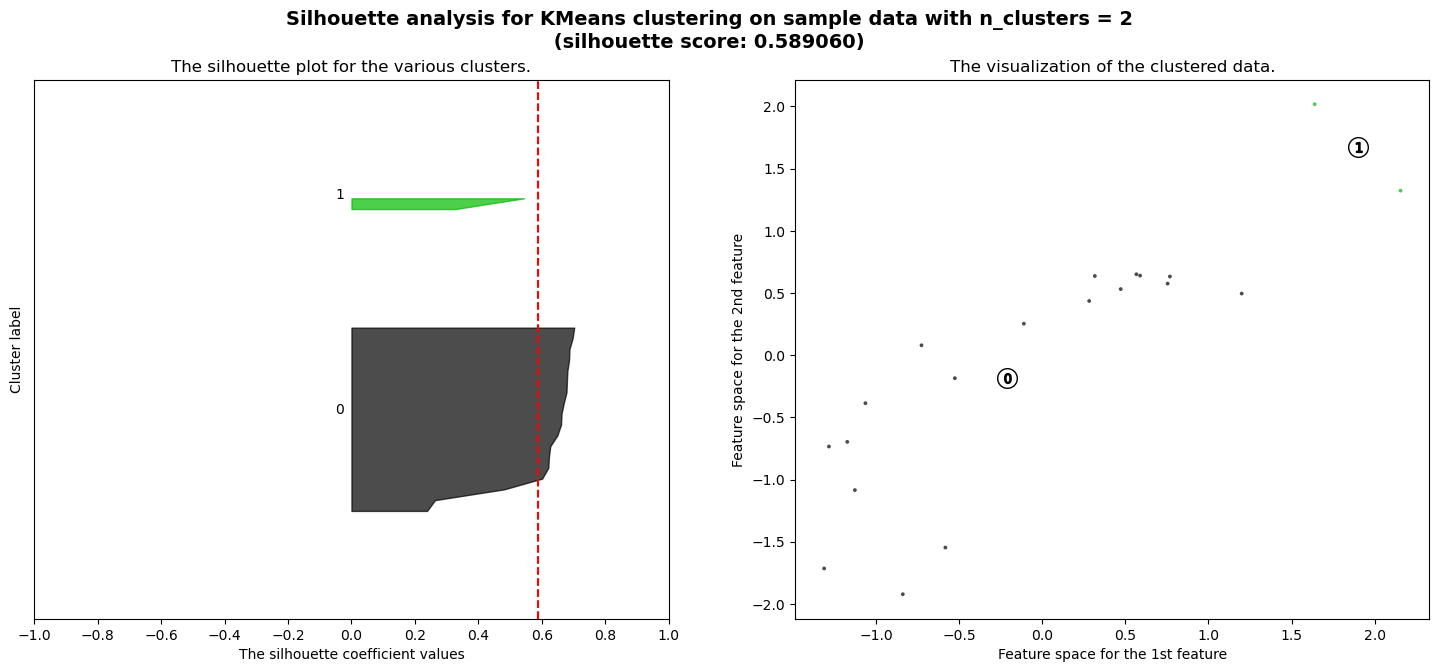

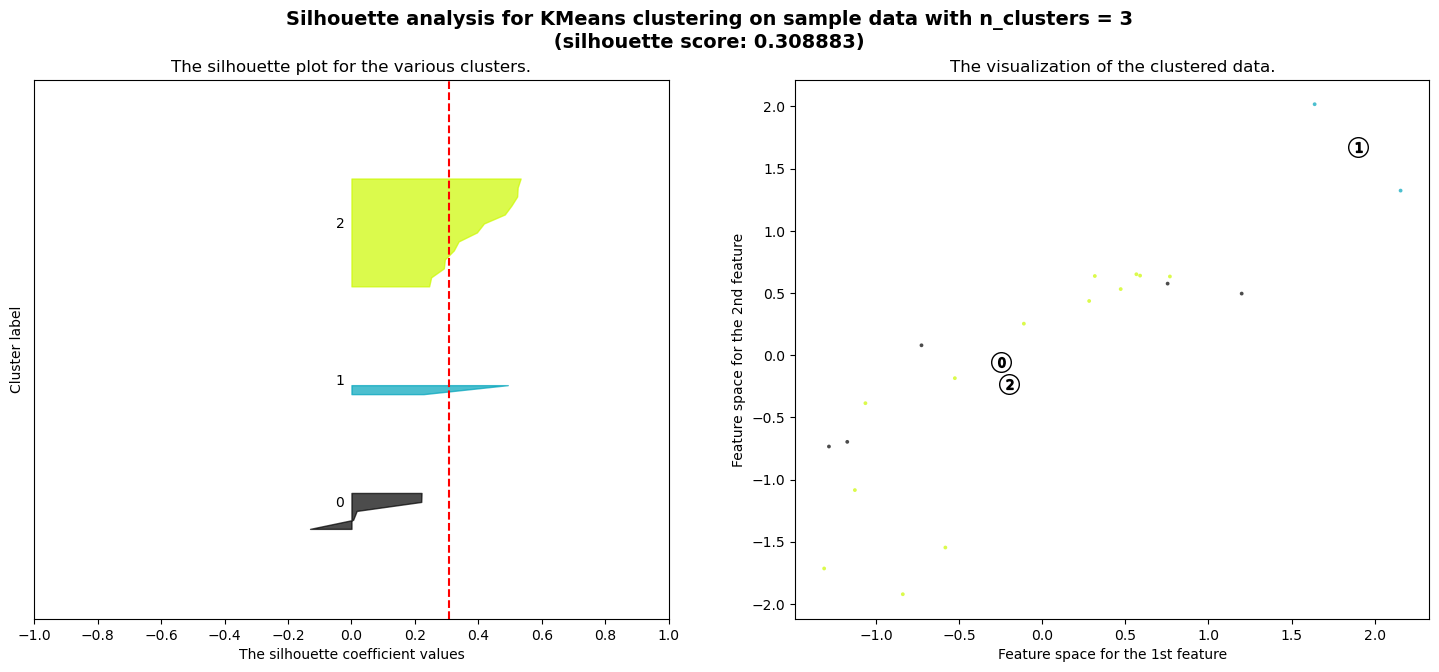

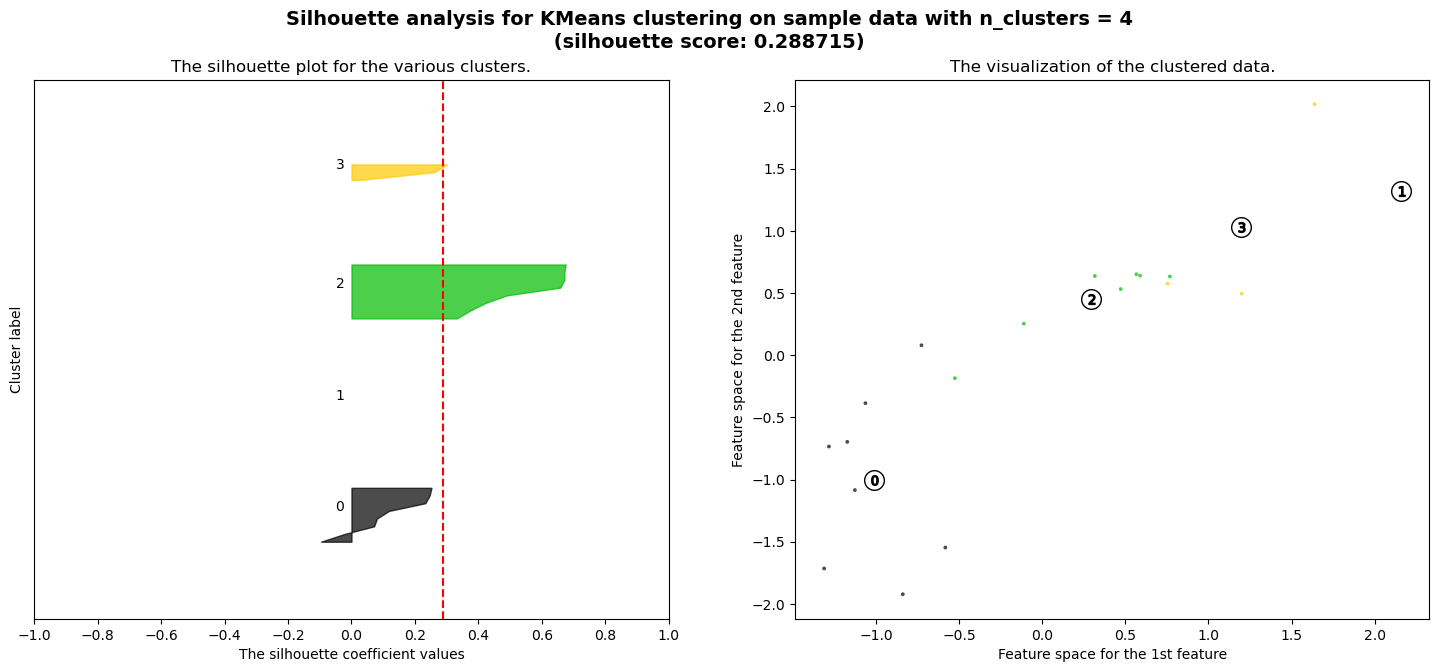

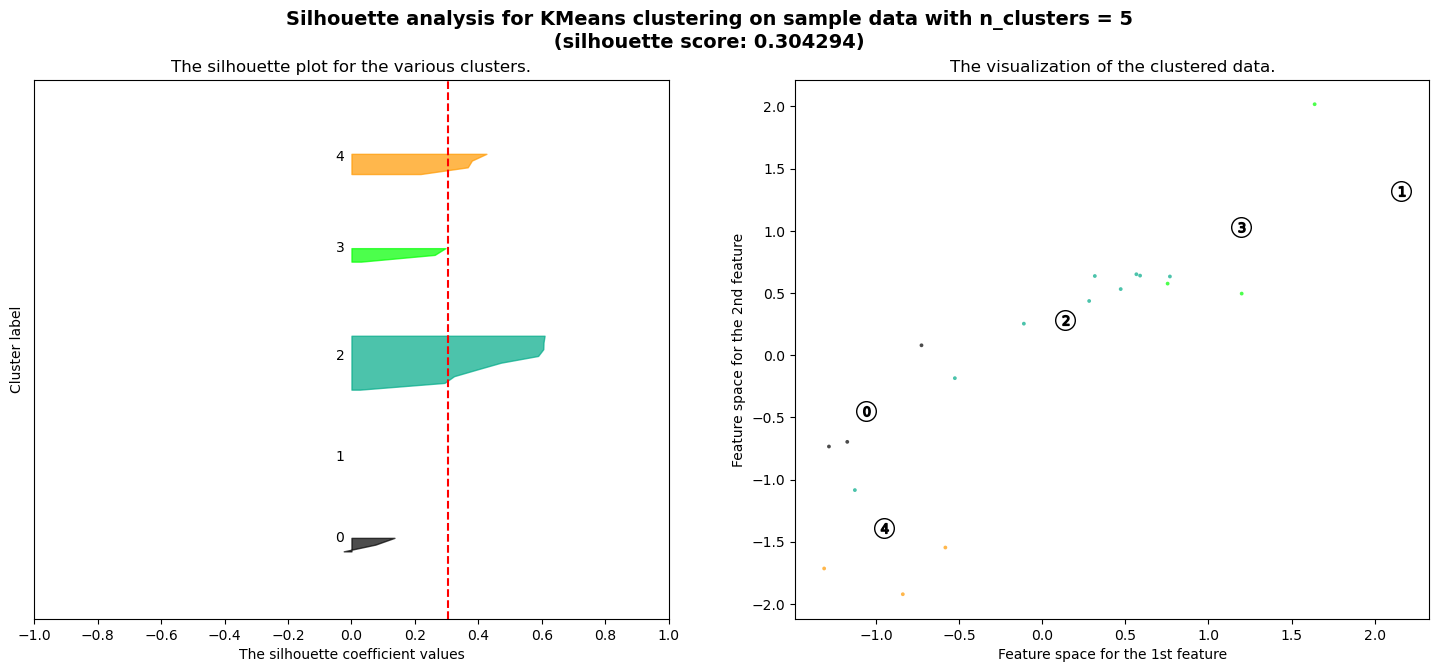

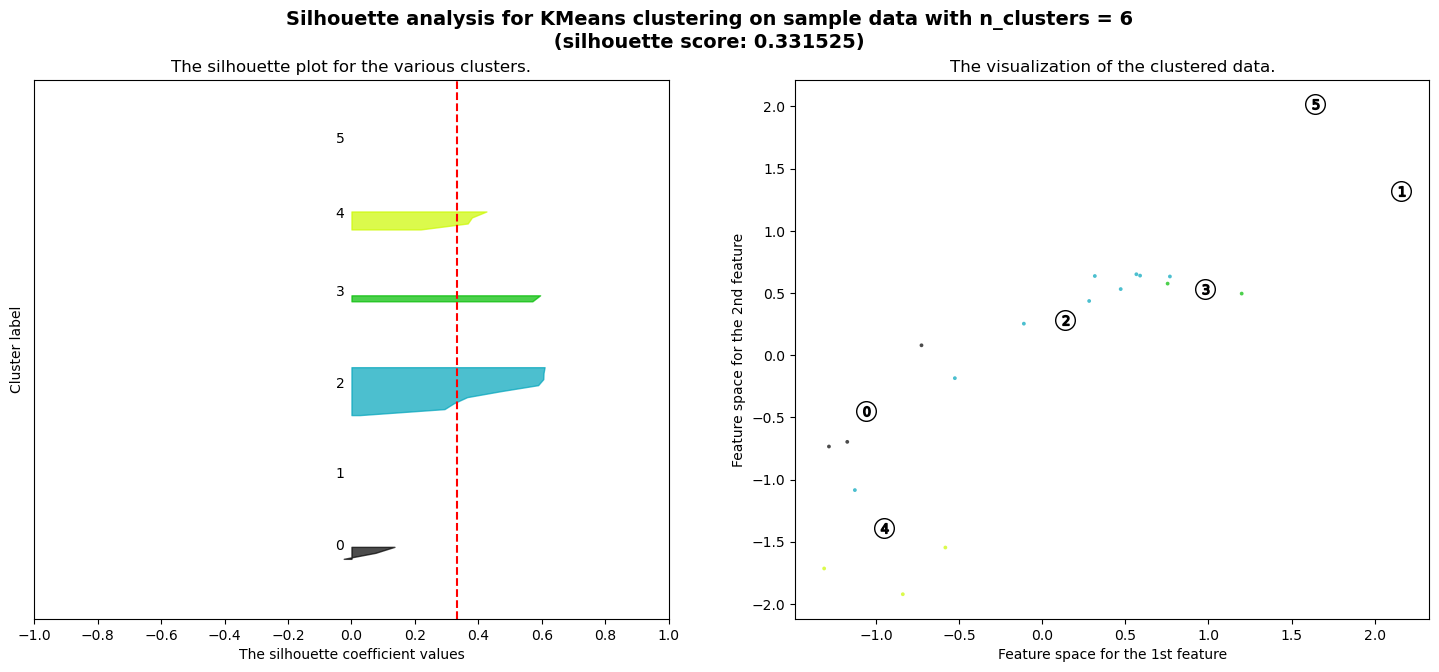

In [216]:
scaler = StandardScaler() 
scaled_X = scaler.fit_transform(X)

range_n_clusters = [2,3,4,5,6]

for n_clusters in range_n_clusters: 
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(scaled_X)+(n_clusters+1)*10])

    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=0)
    cluster_labels = kmeans.fit_predict(scaled_X)

    silhouette_avg = silhouette_score(scaled_X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    sample_silhouette_values = silhouette_samples(scaled_X, cluster_labels)

    y_lower = 10 
    for i in range(n_clusters): 
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])


    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        scaled_X[:, 0], scaled_X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = {}\n (silhouette score: {:2f}) ".format(n_clusters, silhouette_avg),
        fontsize=14,
        fontweight="bold",
    )

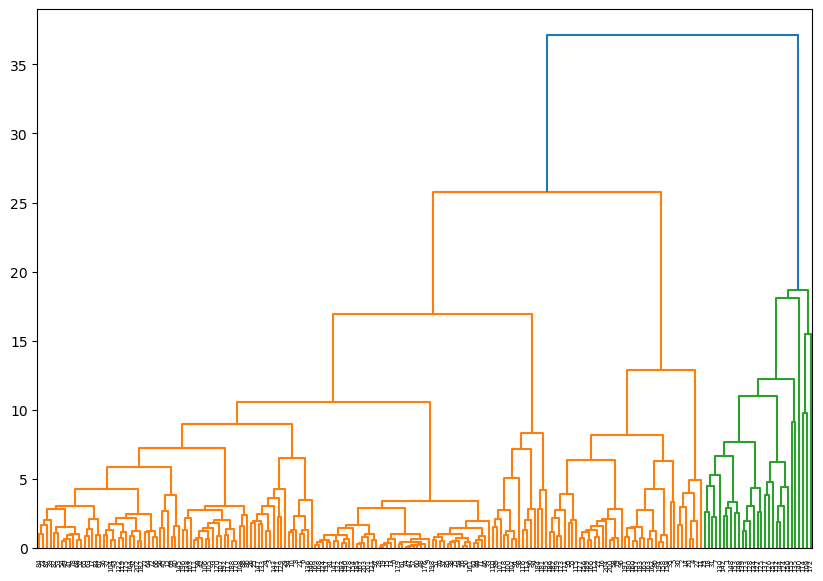

In [251]:
from scipy.cluster.hierarchy import dendrogram, linkage 
from scipy.cluster.hierarchy import fcluster 

scaler = StandardScaler() 
scaled_X = scaler.fit_transform(X)

linked = linkage(scaled_X, 'ward')
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

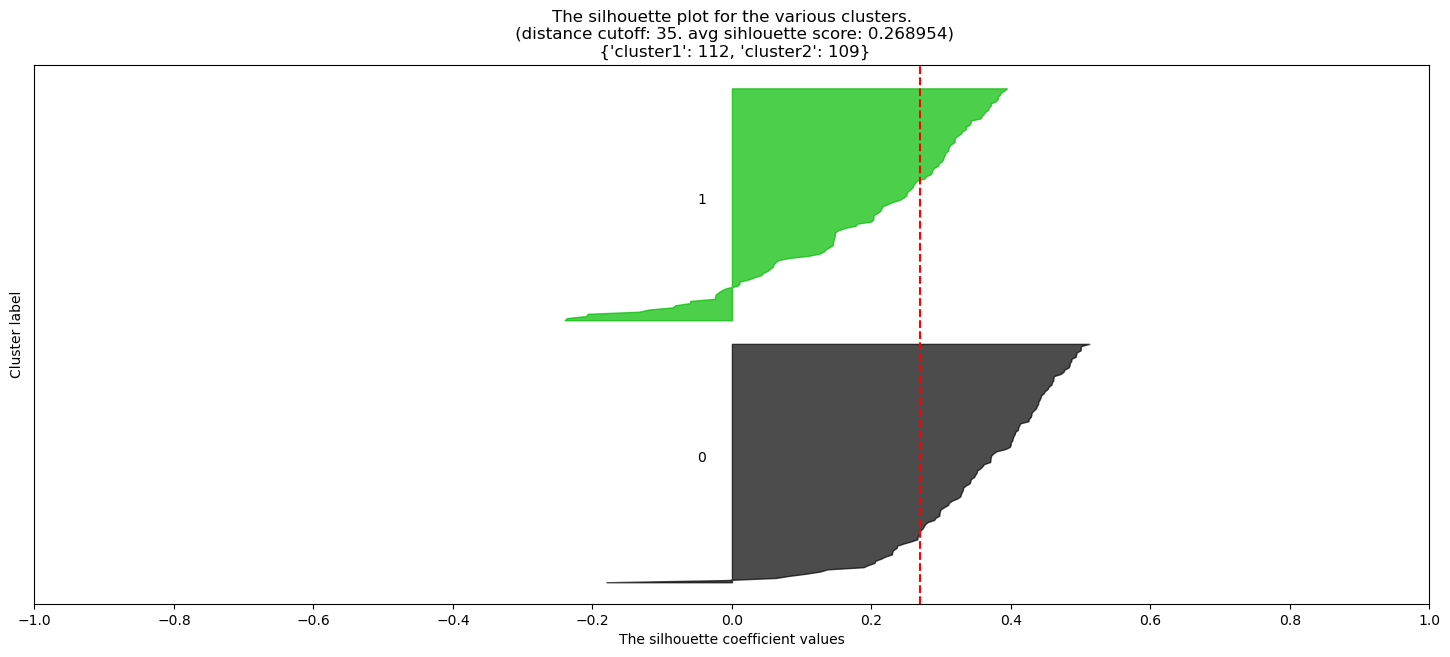

In [247]:
cutoff = 35

predict = pd.DataFrame(fcluster(linked, cutoff, criterion='distance'))
predict.columns = ['predict']
n_clusters = len(pd.value_counts(predict['predict']).index)

# plotting result
fig, ax1  = plt.subplots(1,1)
fig.set_size_inches(18, 7)

ax1.set_xlim([-1, 1])
ax1.set_ylim([0, len(scaled_X)+(n_clusters+1)*10])

silhouette_avg = silhouette_score(scaled_X, predict['predict'].values)
sample_silhouette_values = silhouette_samples(scaled_X, predict['predict'].values)

y_lower = 10 
for i in range(n_clusters): 
    ith_cluster_silhouette_values = sample_silhouette_values[predict['predict'].values == i + 1]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10 
# summarizing    
subject_per_label = {} 
for i, k in enumerate(pd.value_counts(predict['predict']).index): 
    subject_per_label['cluster%s' % str(k)] = pd.value_counts(predict['predict']).values[i]
ax1.set_title("The silhouette plot for the various clusters.\n (distance cutoff: {}. avg sihlouette score: {:2f})\n {}".format(cutoff, silhouette_avg,subject_per_label))
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])



## Case_Case

In [203]:
# using kmean clustering

from scipy.stats import pearsonr, ttest_ind 
# parameters
pathology = 'case_case'
if pathology == 'case_control':
    pheno_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_case_control_merge.csv'
elif pathology == 'control_case':
    pheno_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_control_case_merge.csv' 
elif pathology == 'case_case': 
    pheno_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_case_case_merge.csv'
#year = "after1y"
year = "after2y"
# directories
base_dir =  "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score"
save_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity", pathology])
cluster_save_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label/sensitivity", pathology])

title_list = ['Demographic',  'PolygenicScore', 'SleepDisturbance', 'CBCLSyndrome', 'CBCLDSM', 'CBCL2007']
#title_list = ['Demographic',  'PolygenicScore', 'SleepDisturbance', 'CBCLSyndrome', 'CBCLDSM', 'CBCL2007', 'Screentime_main', 'Screentime_sub']
target_title_dict = {'Demographic': ['BMI_sds_baseline', 'birth_weight', 'child_age', 'high_educ', 'income'],  
                     'PolygenicScore': ['bmieur4', 'edauto', 'insomniaeur6', 'snoringeur1', 'adhdeur6', 'ptsdeur4', 'bipauto',  'mddeur6',  'anxietyauto', 'ocdauto', 'worryauto'] ,
                     'SleepDisturbance': ['sleep_disturb_dims', 'sleep_disturb_sbd', 'sleep_disturb_da', 'sleep_disturb_swtd', 'sleep_disturb_does', 'sleep_disturb_shy', 'sleep_disturb_total'], 
                     'CBCLSyndrome': ["cbcl_anxiety", "cbcl_withdep","cbcl_somatic","cbcl_social","cbcl_thought","cbcl_attention","cbcl_rulebreak","cbcl_aggressive","cbcl_internal","cbcl_external","cbcl_totprob"], 
                     'CBCLDSM': ["cbcl_dsm_depression","cbcl_dsm_anxiety","cbcl_dsm_somatic","cbcl_dsm_adhd","cbcl_dsm_opposit","cbcl_dsm_conduct"], 
                     'CBCL2007': ["cbcl_sct"	,"cbcl_ocd","cbcl_stress"], 
#                     'Screentime_main': ["screentime_wkday_y", "screentime_wkend_y", "screentime_wkday_p", "screentime_wkend_p"], 
#                     'Screentime_sub': ["screentime_wkday_tv","screentime_wkday_videos",	"screentime_wkday_games","screentime_wkday_texting","screentime_wkday_sns", "screentime_wkday_videochat", "screentime_wkend_tv", "screentime_wkend_videos", "screentime_wkend_games", "screentime_wkend_texting", "screentime_wkend_sns", "screentime_wkend_videochat", "screentime_maturegames", "screentime_rmovies"]
                     }

#Kmeans_list = [ "HarvardOxford_Subcortical", "Amygdala"]
Kmeans_list = ["Amygdala"]



for roi in Kmeans_list: 
    # setting hyper parameters
    if roi == 'HarvardOxford_Cortical': 
        data = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == 'HarvardOxford_Subcortical': 
        data = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == 'ReinforcementLearning':
        data = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == "Amygdala": 
        data = os.path.join(*[base_dir, year, "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi ==  "Cerebellum": 
        data = os.path.join(*[base_dir, year, "Cerebellum-MNIfnirt-maxprob-thr25-1mm_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    n_clusters = 2 
    attr_score = pd.read_csv(data)
    pheno_merge = pd.read_csv(pheno_merge_dir)
    attr_score = pd.merge(attr_score, pheno_merge['subjectkey'], how='inner', on='subjectkey')
    print('%s subjects are involved in this analysis' % len(attr_score))
    scaler = StandardScaler() 
    pheno_cluster, pheno_cluster_delta, pheno_control, pheno_delta_control = clustering_KMEANS(base_dir, save_dir_roi, cluster_save_dir, year, data, n_clusters, scaler)

    # performing t test 
    for title in title_list: 
        target_list = target_title_dict[title]
        for target in target_list: 
            if (not target in pheno_cluster.keys()) or (not target in pheno_cluster_delta.keys()) or (not target in pheno_control.keys()) or (not target in pheno_delta_control.keys()):
                target_list.remove(target)
        if (title == 'Demographic')  or (title == 'PolygenicScore'):
            performing_ttest(title=title, target_list=target_list, year=year, pheno_cluster=pheno_cluster, pheno_cluster_delta=pheno_cluster_delta, pheno_control=pheno_control, pheno_delta_control=pheno_delta_control, save_dir=save_dir_roi, delta=False)
        else:
            performing_ttest(title=title, target_list=target_list, year=year, pheno_cluster=pheno_cluster, pheno_cluster_delta=pheno_cluster_delta, pheno_control=pheno_control, pheno_delta_control=pheno_delta_control, save_dir=save_dir_roi, delta=True)


205 subjects are involved in this analysis
0.4561437458410945


KeyboardInterrupt: 

In [260]:
# using heirarchical clustering
from scipy.stats import pearsonr, ttest_ind 
from scipy.cluster.hierarchy import dendrogram, linkage 
from scipy.cluster.hierarchy import fcluster 
from scipy.stats import pearsonr, ttest_ind 
# parameters
pathology = 'case_case'
if pathology == 'case_control':
    pheno_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_case_control_merge.csv'
elif pathology == 'control_case':
    pheno_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_control_case_merge.csv' 
elif pathology == 'case_case': 
    pheno_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_case_case_merge.csv'
#year = "after1y"
year = "after2y"
# directories
base_dir =  "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score"
save_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity", pathology])
cluster_save_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label/sensitivity", pathology])



HarvardOxford_cort_attr_save_dir = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
HarvardOxford_subcort_attr_save_dir = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
ReinforcementLearning_attr_save_dir = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])

title_list = ['Demographic']
title_list = ['Demographic',  'PolygenicScore', 'SleepDisturbance', 'CBCLSyndrome', 'CBCLDSM', 'CBCL2007']
#title_list = ['Demographic',  'PolygenicScore', 'SleepDisturbance', 'CBCLSyndrome', 'CBCLDSM', 'CBCL2007', 'Screentime_main', 'Screentime_sub']
target_title_dict = {'Demographic': ['BMI_sds_baseline', 'birth_weight', 'child_age', 'high_educ', 'income'],  
                     'PolygenicScore': [ 'bmieur4', 'edauto', 'insomniaeur6', 'snoringeur1', 'adhdeur6', 'ptsdeur4', 'bipauto',  'mddeur6',  'anxietyauto', 'ocdauto', 'worryauto'] ,
                     'SleepDisturbance': ['sleep_disturb_dims', 'sleep_disturb_sbd', 'sleep_disturb_da', 'sleep_disturb_swtd', 'sleep_disturb_does', 'sleep_disturb_shy', 'sleep_disturb_total'], 
                     'CBCLSyndrome': ["cbcl_anxiety", "cbcl_withdep","cbcl_somatic","cbcl_social","cbcl_thought","cbcl_attention","cbcl_rulebreak","cbcl_aggressive","cbcl_internal","cbcl_external","cbcl_totprob"], 
                     'CBCLDSM': ["cbcl_dsm_depression","cbcl_dsm_anxiety","cbcl_dsm_somatic","cbcl_dsm_adhd","cbcl_dsm_opposit","cbcl_dsm_conduct"], 
                     'CBCL2007': ["cbcl_sct"	,"cbcl_ocd","cbcl_stress"], 
                     #'Screentime_main': ["screentime_wkday_y", "screentime_wkend_y", "screentime_wkday_p", "screentime_wkend_p"], 
                     #'Screentime_sub': ["screentime_wkday_tv","screentime_wkday_videos",	"screentime_wkday_games","screentime_wkday_texting","screentime_wkday_sns", "screentime_wkday_videochat", "screentime_wkend_tv", "screentime_wkend_videos", "screentime_wkend_games", "screentime_wkend_texting", "screentime_wkend_sns", "screentime_wkend_videochat", "screentime_maturegames", "screentime_rmovies"]
                     }

#heirarch_list = ["ReinforcementLearning"]
#cutoff_list = [35]
heirarch_list = [ "HarvardOxford_Subcortical", "ReinforcementLearning"]
cutoff_list = [35, 35]


for roi, cutoff in zip(heirarch_list, cutoff_list): 
    # setting hyper parameters
    if roi == 'HarvardOxford_Cortical': 
        data = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == 'HarvardOxford_Subcortical': 
        data = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == 'ReinforcementLearning':
        data = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == "Amygdala": 
        data = os.path.join(*[base_dir, year, "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi ==  "Cerebellum": 
        data = os.path.join(*[base_dir, year, "Cerebellum-MNIfnirt-maxprob-thr25-1mm_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    attr_score = pd.read_csv(data)
    pheno_merge = pd.read_csv(pheno_merge_dir)
    attr_score = pd.merge(attr_score, pheno_merge['subjectkey'], how='inner', on='subjectkey')
    print('%s subjects are involved in this analysis' % len(attr_score))
    scaler = StandardScaler() 
    pheno_cluster, pheno_cluster_delta, pheno_control, pheno_delta_control = clustering_HIERARCHICAL(base_dir, save_dir, cluster_save_dir, year, data, cutoff, scaler)

    # performing t test 
    for title in title_list: 
        target_list = target_title_dict[title]
        for target in target_list: 
            if (not target in pheno_cluster.keys()) or (not target in pheno_cluster_delta.keys()) or (not target in pheno_control.keys()) or (not target in pheno_delta_control.keys()):
                target_list.remove(target)
        if (title == 'Demographic')  or (title == 'PolygenicScore'):
            performing_ttest(title=title, target_list=target_list, year=year, pheno_cluster=pheno_cluster, pheno_cluster_delta=pheno_cluster_delta, pheno_control=pheno_control, pheno_delta_control=pheno_delta_control, save_dir=save_dir_roi, delta=False)
        else:
            performing_ttest(title=title, target_list=target_list, year=year, pheno_cluster=pheno_cluster, pheno_cluster_delta=pheno_cluster_delta, pheno_control=pheno_control, pheno_delta_control=pheno_delta_control, save_dir=save_dir_roi, delta=True)



205 subjects are involved in this analysis
0.28752505226347796
birth_weight Done
child_age Done
high_educ Done
income Done
bmieur4 Done
edauto Done
insomniaeur6 Done
snoringeur1 Done
adhdeur6 Done
ptsdeur4 Done
bipauto Done
mddeur6 Done
anxietyauto Done
ocdauto Done
worryauto Done
sleep_disturb_dims Done
sleep_disturb_sbd Done
sleep_disturb_da Done
sleep_disturb_swtd Done
sleep_disturb_does Done
sleep_disturb_shy Done
sleep_disturb_total Done
sleep_disturb_dims Done
sleep_disturb_sbd Done
sleep_disturb_da Done
sleep_disturb_swtd Done
sleep_disturb_does Done
sleep_disturb_shy Done
sleep_disturb_total Done
cbcl_anxiety Done
cbcl_withdep Done
cbcl_somatic Done
cbcl_social Done
cbcl_thought Done
cbcl_attention Done
cbcl_rulebreak Done
cbcl_aggressive Done
cbcl_internal Done
cbcl_external Done
cbcl_totprob Done
cbcl_anxiety Done
cbcl_withdep Done
cbcl_somatic Done
cbcl_social Done
cbcl_thought Done
cbcl_attention Done
cbcl_rulebreak Done
cbcl_aggressive Done
cbcl_internal Done
cbcl_external

## Case_Control

In [263]:
# using kmean clustering

from scipy.stats import pearsonr, ttest_ind 
# parameters
pathology = 'case_control'
if pathology == 'case_control':
    pheno_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_case_control_merge.csv'
elif pathology == 'control_case':
    pheno_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_control_case_merge.csv' 
elif pathology == 'case_case': 
    pheno_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_case_case_merge.csv'
year = "after1y"

# directories
base_dir =  "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score"
save_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity", pathology])
cluster_save_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label/sensitivity", pathology])

title_list = ['Demographic',  'PolygenicScore', 'SleepDisturbance', 'CBCLSyndrome', 'CBCLDSM', 'CBCL2007']
#title_list = ['Demographic',  'PolygenicScore', 'SleepDisturbance', 'CBCLSyndrome', 'CBCLDSM', 'CBCL2007', 'Screentime_main', 'Screentime_sub']
target_title_dict = {'Demographic': ['BMI_sds_baseline', 'birth_weight', 'child_age', 'high_educ', 'income'],  
                     'PolygenicScore': ['bmieur4', 'edauto', 'insomniaeur6', 'snoringeur1', 'adhdeur6', 'ptsdeur4', 'bipauto',  'mddeur6',  'anxietyauto', 'ocdauto', 'worryauto'] ,
                     'SleepDisturbance': ['sleep_disturb_dims', 'sleep_disturb_sbd', 'sleep_disturb_da', 'sleep_disturb_swtd', 'sleep_disturb_does', 'sleep_disturb_shy', 'sleep_disturb_total'], 
                     'CBCLSyndrome': ["cbcl_anxiety", "cbcl_withdep","cbcl_somatic","cbcl_social","cbcl_thought","cbcl_attention","cbcl_rulebreak","cbcl_aggressive","cbcl_internal","cbcl_external","cbcl_totprob"], 
                     'CBCLDSM': ["cbcl_dsm_depression","cbcl_dsm_anxiety","cbcl_dsm_somatic","cbcl_dsm_adhd","cbcl_dsm_opposit","cbcl_dsm_conduct"], 
                     'CBCL2007': ["cbcl_sct"	,"cbcl_ocd","cbcl_stress"], 
#                     'Screentime_main': ["screentime_wkday_y", "screentime_wkend_y", "screentime_wkday_p", "screentime_wkend_p"], 
#                     'Screentime_sub': ["screentime_wkday_tv","screentime_wkday_videos",	"screentime_wkday_games","screentime_wkday_texting","screentime_wkday_sns", "screentime_wkday_videochat", "screentime_wkend_tv", "screentime_wkend_videos", "screentime_wkend_games", "screentime_wkend_texting", "screentime_wkend_sns", "screentime_wkend_videochat", "screentime_maturegames", "screentime_rmovies"]
                     }

Kmeans_list = [ "HarvardOxford_Subcortical", "Amygdala"]
#Kmeans_list = ["Amygdala"]



for roi in Kmeans_list: 
    # setting hyper parameters
    if roi == 'HarvardOxford_Cortical': 
        data = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == 'HarvardOxford_Subcortical': 
        data = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == 'ReinforcementLearning':
        data = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == "Amygdala": 
        data = os.path.join(*[base_dir, year, "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi ==  "Cerebellum": 
        data = os.path.join(*[base_dir, year, "Cerebellum-MNIfnirt-maxprob-thr25-1mm_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    n_clusters = 2 
    attr_score = pd.read_csv(data)
    pheno_merge = pd.read_csv(pheno_merge_dir)
    attr_score = pd.merge(attr_score, pheno_merge['subjectkey'], how='inner', on='subjectkey')
    print('%s subjects are involved in this analysis' % len(attr_score))
    scaler = StandardScaler() 
    pheno_cluster, pheno_cluster_delta, pheno_control, pheno_delta_control = clustering_KMEANS(base_dir, save_dir_roi, cluster_save_dir, year, data, n_clusters, scaler)

    # performing t test 
    for title in title_list: 
        target_list = target_title_dict[title]
        for target in target_list: 
            if (not target in pheno_cluster.keys()) or (not target in pheno_cluster_delta.keys()) or (not target in pheno_control.keys()) or (not target in pheno_delta_control.keys()):
                target_list.remove(target)
        if (title == 'Demographic')  or (title == 'PolygenicScore'):
            performing_ttest(title=title, target_list=target_list, year=year, pheno_cluster=pheno_cluster, pheno_cluster_delta=pheno_cluster_delta, pheno_control=pheno_control, pheno_delta_control=pheno_delta_control, save_dir=save_dir_roi, delta=False)
        else:
            performing_ttest(title=title, target_list=target_list, year=year, pheno_cluster=pheno_cluster, pheno_cluster_delta=pheno_cluster_delta, pheno_control=pheno_control, pheno_delta_control=pheno_delta_control, save_dir=save_dir_roi, delta=True)


130 subjects are involved in this analysis
0.34522631369173196
birth_weight Done
child_age Done
high_educ Done
income Done
130 subjects are involved in this analysis
0.47029825597849556
birth_weight Done
child_age Done
high_educ Done
income Done


In [256]:
# using heirarchical clustering
from scipy.stats import pearsonr, ttest_ind 
from scipy.cluster.hierarchy import dendrogram, linkage 
from scipy.cluster.hierarchy import fcluster 
from scipy.stats import pearsonr, ttest_ind 
# parameters
pathology = 'case_control'
if pathology == 'case_control':
    pheno_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_case_control_merge.csv'
elif pathology == 'control_case':
    pheno_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_control_case_merge.csv' 
elif pathology == 'case_case': 
    pheno_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_case_case_merge.csv'
year = "after1y"

# directories
base_dir =  "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score"
save_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity", pathology])
cluster_save_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label/sensitivity", pathology])



HarvardOxford_cort_attr_save_dir = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
HarvardOxford_subcort_attr_save_dir = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
ReinforcementLearning_attr_save_dir = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])


title_list = ['Demographic',  'PolygenicScore', 'SleepDisturbance', 'CBCLSyndrome', 'CBCLDSM', 'CBCL2007']
#title_list = ['Demographic',  'PolygenicScore', 'SleepDisturbance', 'CBCLSyndrome', 'CBCLDSM', 'CBCL2007', 'Screentime_main', 'Screentime_sub']
target_title_dict = {'Demographic': ['BMI_sds_baseline', 'birth_weight', 'child_age', 'high_educ', 'income'],  
                     'PolygenicScore': [ 'bmieur4', 'edauto', 'insomniaeur6', 'snoringeur1', 'adhdeur6', 'ptsdeur4', 'bipauto',  'mddeur6',  'anxietyauto', 'ocdauto', 'worryauto'] ,
                     'SleepDisturbance': ['sleep_disturb_dims', 'sleep_disturb_sbd', 'sleep_disturb_da', 'sleep_disturb_swtd', 'sleep_disturb_does', 'sleep_disturb_shy', 'sleep_disturb_total'], 
                     'CBCLSyndrome': ["cbcl_anxiety", "cbcl_withdep","cbcl_somatic","cbcl_social","cbcl_thought","cbcl_attention","cbcl_rulebreak","cbcl_aggressive","cbcl_internal","cbcl_external","cbcl_totprob"], 
                     'CBCLDSM': ["cbcl_dsm_depression","cbcl_dsm_anxiety","cbcl_dsm_somatic","cbcl_dsm_adhd","cbcl_dsm_opposit","cbcl_dsm_conduct"], 
                     'CBCL2007': ["cbcl_sct"	,"cbcl_ocd","cbcl_stress"], 
                     #'Screentime_main': ["screentime_wkday_y", "screentime_wkend_y", "screentime_wkday_p", "screentime_wkend_p"], 
                     #'Screentime_sub': ["screentime_wkday_tv","screentime_wkday_videos",	"screentime_wkday_games","screentime_wkday_texting","screentime_wkday_sns", "screentime_wkday_videochat", "screentime_wkend_tv", "screentime_wkend_videos", "screentime_wkend_games", "screentime_wkend_texting", "screentime_wkend_sns", "screentime_wkend_videochat", "screentime_maturegames", "screentime_rmovies"]
                     }

heirarch_list = ["ReinforcementLearning"]
cutoff_list = [27]
#heirarch_list = [ "HarvardOxford_Subcortical", "ReinforcementLearning"]
#cutoff_list = [35, 35]


for roi, cutoff in zip(heirarch_list, cutoff_list): 
    # setting hyper parameters
    if roi == 'HarvardOxford_Cortical': 
        data = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == 'HarvardOxford_Subcortical': 
        data = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == 'ReinforcementLearning':
        data = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == "Amygdala": 
        data = os.path.join(*[base_dir, year, "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi ==  "Cerebellum": 
        data = os.path.join(*[base_dir, year, "Cerebellum-MNIfnirt-maxprob-thr25-1mm_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    attr_score = pd.read_csv(data)
    pheno_merge = pd.read_csv(pheno_merge_dir)
    attr_score = pd.merge(attr_score, pheno_merge['subjectkey'], how='inner', on='subjectkey')
    print('%s subjects are involved in this analysis' % len(attr_score))
    scaler = StandardScaler() 
    pheno_cluster, pheno_cluster_delta, pheno_control, pheno_delta_control = clustering_HIERARCHICAL(base_dir, save_dir, cluster_save_dir, year, data, cutoff, scaler)

    # performing t test 
    for title in title_list: 
        target_list = target_title_dict[title]
        for target in target_list: 
            if (not target in pheno_cluster.keys()) or (not target in pheno_cluster_delta.keys()) or (not target in pheno_control.keys()) or (not target in pheno_delta_control.keys()):
                target_list.remove(target)
        if (title == 'Demographic')  or (title == 'PolygenicScore'):
            performing_ttest(title=title, target_list=target_list, year=year, pheno_cluster=pheno_cluster, pheno_cluster_delta=pheno_cluster_delta, pheno_control=pheno_control, pheno_delta_control=pheno_delta_control, save_dir=save_dir_roi, delta=False)
        else:
            performing_ttest(title=title, target_list=target_list, year=year, pheno_cluster=pheno_cluster, pheno_cluster_delta=pheno_cluster_delta, pheno_control=pheno_control, pheno_delta_control=pheno_delta_control, save_dir=save_dir_roi, delta=True)



130 subjects are involved in this analysis
0.5138586203127691
birth_weight Done
child_age Done
high_educ Done
income Done
bmieur4 Done
edauto Done
insomniaeur6 Done
snoringeur1 Done
adhdeur6 Done
ptsdeur4 Done
bipauto Done
mddeur6 Done
anxietyauto Done
ocdauto Done
worryauto Done
sleep_disturb_dims Done
sleep_disturb_sbd Done
sleep_disturb_da Done
sleep_disturb_swtd Done
sleep_disturb_does Done
sleep_disturb_shy Done
sleep_disturb_total Done
sleep_disturb_dims Done
sleep_disturb_sbd Done
sleep_disturb_da Done
sleep_disturb_swtd Done
sleep_disturb_does Done
sleep_disturb_shy Done
sleep_disturb_total Done
cbcl_anxiety Done
cbcl_withdep Done
cbcl_somatic Done
cbcl_social Done
cbcl_thought Done
cbcl_attention Done
cbcl_rulebreak Done
cbcl_aggressive Done
cbcl_internal Done
cbcl_external Done
cbcl_totprob Done
cbcl_anxiety Done
cbcl_withdep Done
cbcl_somatic Done
cbcl_social Done
cbcl_thought Done
cbcl_attention Done
cbcl_rulebreak Done
cbcl_aggressive Done
cbcl_internal Done
cbcl_external 

# Control_Case

In [257]:
# using kmean clustering

from scipy.stats import pearsonr, ttest_ind 
# parameters
pathology = 'control_case'
if pathology == 'case_control':
    pheno_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_case_control_merge.csv'
elif pathology == 'control_case':
    pheno_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_control_case_merge.csv' 
elif pathology == 'case_case': 
    pheno_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_case_case_merge.csv'
#year = "after1y"
year = "after2y"
# directories
base_dir =  "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score"
save_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity", pathology])
cluster_save_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label/sensitivity", pathology])

title_list = ['Demographic',  'PolygenicScore', 'SleepDisturbance', 'CBCLSyndrome', 'CBCLDSM', 'CBCL2007']
#title_list = ['Demographic',  'PolygenicScore', 'SleepDisturbance', 'CBCLSyndrome', 'CBCLDSM', 'CBCL2007', 'Screentime_main', 'Screentime_sub']
target_title_dict = {'Demographic': ['BMI_sds_baseline', 'birth_weight', 'child_age', 'high_educ', 'income'],  
                     'PolygenicScore': ['bmieur4', 'edauto', 'insomniaeur6', 'snoringeur1', 'adhdeur6', 'ptsdeur4', 'bipauto',  'mddeur6',  'anxietyauto', 'ocdauto', 'worryauto'] ,
                     'SleepDisturbance': ['sleep_disturb_dims', 'sleep_disturb_sbd', 'sleep_disturb_da', 'sleep_disturb_swtd', 'sleep_disturb_does', 'sleep_disturb_shy', 'sleep_disturb_total'], 
                     'CBCLSyndrome': ["cbcl_anxiety", "cbcl_withdep","cbcl_somatic","cbcl_social","cbcl_thought","cbcl_attention","cbcl_rulebreak","cbcl_aggressive","cbcl_internal","cbcl_external","cbcl_totprob"], 
                     'CBCLDSM': ["cbcl_dsm_depression","cbcl_dsm_anxiety","cbcl_dsm_somatic","cbcl_dsm_adhd","cbcl_dsm_opposit","cbcl_dsm_conduct"], 
                     'CBCL2007': ["cbcl_sct"	,"cbcl_ocd","cbcl_stress"], 
#                     'Screentime_main': ["screentime_wkday_y", "screentime_wkend_y", "screentime_wkday_p", "screentime_wkend_p"], 
#                     'Screentime_sub': ["screentime_wkday_tv","screentime_wkday_videos",	"screentime_wkday_games","screentime_wkday_texting","screentime_wkday_sns", "screentime_wkday_videochat", "screentime_wkend_tv", "screentime_wkend_videos", "screentime_wkend_games", "screentime_wkend_texting", "screentime_wkend_sns", "screentime_wkend_videochat", "screentime_maturegames", "screentime_rmovies"]
                     }

#Kmeans_list = [ "HarvardOxford_Subcortical", "Amygdala"]
Kmeans_list = ["Amygdala"]



for roi in Kmeans_list: 
    # setting hyper parameters
    if roi == 'HarvardOxford_Cortical': 
        data = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == 'HarvardOxford_Subcortical': 
        data = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == 'ReinforcementLearning':
        data = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == "Amygdala": 
        data = os.path.join(*[base_dir, year, "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi ==  "Cerebellum": 
        data = os.path.join(*[base_dir, year, "Cerebellum-MNIfnirt-maxprob-thr25-1mm_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    n_clusters = 2 
    attr_score = pd.read_csv(data)
    pheno_merge = pd.read_csv(pheno_merge_dir)
    attr_score = pd.merge(attr_score, pheno_merge['subjectkey'], how='inner', on='subjectkey')
    print('%s subjects are involved in this analysis' % len(attr_score))
    scaler = StandardScaler() 
    pheno_cluster, pheno_cluster_delta, pheno_control, pheno_delta_control = clustering_KMEANS(base_dir, save_dir_roi, cluster_save_dir, year, data, n_clusters, scaler)

    # performing t test 
    for title in title_list: 
        target_list = target_title_dict[title]
        for target in target_list: 
            if (not target in pheno_cluster.keys()) or (not target in pheno_cluster_delta.keys()) or (not target in pheno_control.keys()) or (not target in pheno_delta_control.keys()):
                target_list.remove(target)
        if (title == 'Demographic')  or (title == 'PolygenicScore'):
            performing_ttest(title=title, target_list=target_list, year=year, pheno_cluster=pheno_cluster, pheno_cluster_delta=pheno_cluster_delta, pheno_control=pheno_control, pheno_delta_control=pheno_delta_control, save_dir=save_dir_roi, delta=False)
        else:
            performing_ttest(title=title, target_list=target_list, year=year, pheno_cluster=pheno_cluster, pheno_cluster_delta=pheno_cluster_delta, pheno_control=pheno_control, pheno_delta_control=pheno_delta_control, save_dir=save_dir_roi, delta=True)


221 subjects are involved in this analysis
0.42358867925900234
birth_weight Done
child_age Done
high_educ Done
income Done
bmieur4 Done
edauto Done
insomniaeur6 Done
snoringeur1 Done
adhdeur6 Done
ptsdeur4 Done
bipauto Done
mddeur6 Done
anxietyauto Done
ocdauto Done
worryauto Done
sleep_disturb_dims Done
sleep_disturb_sbd Done
sleep_disturb_da Done
sleep_disturb_swtd Done
sleep_disturb_does Done
sleep_disturb_shy Done
sleep_disturb_total Done
sleep_disturb_dims Done
sleep_disturb_sbd Done
sleep_disturb_da Done
sleep_disturb_swtd Done
sleep_disturb_does Done
sleep_disturb_shy Done
sleep_disturb_total Done
cbcl_anxiety Done
cbcl_withdep Done
cbcl_somatic Done
cbcl_social Done
cbcl_thought Done
cbcl_attention Done
cbcl_rulebreak Done
cbcl_aggressive Done
cbcl_internal Done
cbcl_external Done
cbcl_totprob Done
cbcl_anxiety Done
cbcl_withdep Done
cbcl_somatic Done
cbcl_social Done
cbcl_thought Done
cbcl_attention Done
cbcl_rulebreak Done
cbcl_aggressive Done
cbcl_internal Done
cbcl_external

In [261]:
# using heirarchical clustering
from scipy.stats import pearsonr, ttest_ind 
from scipy.cluster.hierarchy import dendrogram, linkage 
from scipy.cluster.hierarchy import fcluster 
from scipy.stats import pearsonr, ttest_ind 
# parameters
pathology = 'control_case'
if pathology == 'case_control':
    pheno_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_case_control_merge.csv'
elif pathology == 'control_case':
    pheno_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_control_case_merge.csv' 
elif pathology == 'case_case': 
    pheno_merge_dir = '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity/pheno_case_case_merge.csv'

year = "after2y"
# directories
base_dir =  "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score"
save_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/ttest/sensitivity", pathology])
cluster_save_dir = os.path.join(*["/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/cluster_label/sensitivity", pathology])



HarvardOxford_cort_attr_save_dir = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
HarvardOxford_subcort_attr_save_dir = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
ReinforcementLearning_attr_save_dir = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])

title_list = ['CBCL2007']
#title_list = ['Demographic',  'PolygenicScore', 'SleepDisturbance', 'CBCLSyndrome', 'CBCLDSM', 'CBCL2007']
#title_list = ['Demographic',  'PolygenicScore', 'SleepDisturbance', 'CBCLSyndrome', 'CBCLDSM', 'CBCL2007', 'Screentime_main', 'Screentime_sub']
target_title_dict = {'Demographic': ['BMI_sds_baseline', 'birth_weight', 'child_age', 'high_educ', 'income'],  
                     'PolygenicScore': [ 'bmieur4', 'edauto', 'insomniaeur6', 'snoringeur1', 'adhdeur6', 'ptsdeur4', 'bipauto',  'mddeur6',  'anxietyauto', 'ocdauto', 'worryauto'] ,
                     'SleepDisturbance': ['sleep_disturb_dims', 'sleep_disturb_sbd', 'sleep_disturb_da', 'sleep_disturb_swtd', 'sleep_disturb_does', 'sleep_disturb_shy', 'sleep_disturb_total'], 
                     'CBCLSyndrome': ["cbcl_anxiety", "cbcl_withdep","cbcl_somatic","cbcl_social","cbcl_thought","cbcl_attention","cbcl_rulebreak","cbcl_aggressive","cbcl_internal","cbcl_external","cbcl_totprob"], 
                     'CBCLDSM': ["cbcl_dsm_depression","cbcl_dsm_anxiety","cbcl_dsm_somatic","cbcl_dsm_adhd","cbcl_dsm_opposit","cbcl_dsm_conduct"], 
                     'CBCL2007': ["cbcl_sct"	,"cbcl_ocd","cbcl_stress"], 
                     #'Screentime_main': ["screentime_wkday_y", "screentime_wkend_y", "screentime_wkday_p", "screentime_wkend_p"], 
                     #'Screentime_sub': ["screentime_wkday_tv","screentime_wkday_videos",	"screentime_wkday_games","screentime_wkday_texting","screentime_wkday_sns", "screentime_wkday_videochat", "screentime_wkend_tv", "screentime_wkend_videos", "screentime_wkend_games", "screentime_wkend_texting", "screentime_wkend_sns", "screentime_wkend_videochat", "screentime_maturegames", "screentime_rmovies"]
                     }

heirarch_list = ["ReinforcementLearning"]
cutoff_list = [35]
#heirarch_list = [ "HarvardOxford_Subcortical", "ReinforcementLearning"]
#cutoff_list = [35, 35]


for roi, cutoff in zip(heirarch_list, cutoff_list): 
    # setting hyper parameters
    if roi == 'HarvardOxford_Cortical': 
        data = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == 'HarvardOxford_Subcortical': 
        data = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore_revised.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == 'ReinforcementLearning':
        data = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi == "Amygdala": 
        data = os.path.join(*[base_dir, year, "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    elif roi ==  "Cerebellum": 
        data = os.path.join(*[base_dir, year, "Cerebellum-MNIfnirt-maxprob-thr25-1mm_MeanAttrScore.csv"])
        save_dir_roi = os.path.join(*[save_dir, roi])
    attr_score = pd.read_csv(data)
    pheno_merge = pd.read_csv(pheno_merge_dir)
    attr_score = pd.merge(attr_score, pheno_merge['subjectkey'], how='inner', on='subjectkey')
    print('%s subjects are involved in this analysis' % len(attr_score))
    scaler = StandardScaler() 
    pheno_cluster, pheno_cluster_delta, pheno_control, pheno_delta_control = clustering_HIERARCHICAL(base_dir, save_dir, cluster_save_dir, year, data, cutoff, scaler)

    # performing t test 
    for title in title_list: 
        target_list = target_title_dict[title]
        for target in target_list: 
            if (not target in pheno_cluster.keys()) or (not target in pheno_cluster_delta.keys()) or (not target in pheno_control.keys()) or (not target in pheno_delta_control.keys()):
                target_list.remove(target)
        if (title == 'Demographic')  or (title == 'PolygenicScore'):
            performing_ttest(title=title, target_list=target_list, year=year, pheno_cluster=pheno_cluster, pheno_cluster_delta=pheno_cluster_delta, pheno_control=pheno_control, pheno_delta_control=pheno_delta_control, save_dir=save_dir_roi, delta=False)
        else:
            performing_ttest(title=title, target_list=target_list, year=year, pheno_cluster=pheno_cluster, pheno_cluster_delta=pheno_cluster_delta, pheno_control=pheno_control, pheno_delta_control=pheno_delta_control, save_dir=save_dir_roi, delta=True)



221 subjects are involved in this analysis
0.48552664659032585
cbcl_sct Done
cbcl_ocd Done
cbcl_stress Done
cbcl_sct Done
cbcl_ocd Done
cbcl_stress Done


# Visualizing

In [ ]:
# using kmean clustering

from scipy.stats import pearsonr, ttest_ind 
# parameters
base_dir =  "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering"
year = "after1y"

HarvardOxford_cort_attr_save_dir = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
HarvardOxford_subcort_attr_save_dir = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore.csv"])
cerebellum_attr_save_dir = os.path.join(*[base_dir, year, "Cerebellum-MNIfnirt-maxprob-thr25-1mm_MeanAttrScore.csv"])
ReinforcementLearning_attr_save_dir = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
Amygdala_attr_save_dir = os.path.join(*[base_dir, year, "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])

all = False 
data = ReinforcementLearning_attr_save_dir
n_clusters = 2 
attr_score = pd.read_csv(data)

# filtering case subject 
pheno = pd.read_csv('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/ABCD_phenotype_total_1years_become_overweight_10PS_stratified_partitioned_5fold.csv')
case_subject_list = list(pheno[pheno['become_overweight'] == 1]['subjectkey'].values)
case_subject_list = pd.DataFrame({'subjectkey': case_subject_list})
attr_score_filtered = pd.merge(attr_score, case_subject_list, how='inner', on='subjectkey')
# fitering case subject for delta 
pheno_delta = pd.read_csv('/Users/wangheehwan/Desktop/CNN_for_BMI/phenotype_data/ABCD Release4.0 Tabular dataset.csv')
for i in range(len(pheno_delta)): 
    pheno_delta['subjectkey'][i] = pheno_delta['subjectkey'][i].replace('_','')
pheno_delta_filtered = pd.merge(pheno_delta, case_subject_list, how='inner', on='subjectkey')

# filtering out subjectkey and zero values
for k in attr_score_filtered.keys(): 
    if k == 'subjectkey':
        attr_score_filtered = attr_score_filtered.drop('subjectkey', axis=1, inplace=False)
    else: 
        if np.sum(attr_score_filtered[k].values) == 0: 
            attr_score_filtered = attr_score_filtered.drop(k, axis=1, inplace=False)
X = attr_score_filtered.values 
scaled_X = scaler.fit_transform(X)


kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=0)
cluster_labels = kmeans.fit_predict(scaled_X)
print(silhouette_score(scaled_X, cluster_labels))
cluster_label_pheno = pd.merge(attr_score, case_subject_list, how='inner', on='subjectkey')
cluster_label_pheno['cluster_label'] = cluster_labels
pheno_cluster1 = pd.merge(pheno, cluster_label_pheno[['subjectkey', 'cluster_label']], how='inner', on='subjectkey')
pheno_cluster_delta1 = pd.merge(pheno_delta_filtered, cluster_label_pheno[['subjectkey', 'cluster_label']], how='inner', on='subjectkey')



FileNotFoundError: [Errno 2] No such file or directory: '/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/after1y/CIT168toMNI152-FSL_det_MeanAttrScore.csv'

In [ ]:
# using hierarchical clustering

from scipy.stats import pearsonr, ttest_ind 
# parameters
base_dir =  "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering"
year = "after1y"

HarvardOxford_cort_attr_save_dir = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
HarvardOxford_subcort_attr_save_dir = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore.csv"])
cerebellum_attr_save_dir = os.path.join(*[base_dir, year, "Cerebellum-MNIfnirt-maxprob-thr25-1mm_MeanAttrScore.csv"])
ReinforcementLearning_attr_save_dir = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])
Amygdala_attr_save_dir = os.path.join(*[base_dir, year, "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])

all = False 
data = ReinforcementLearning_attr_save_dir
cutoff = 70
attr_score = pd.read_csv(data)

# filtering case subject 
pheno = pd.read_csv('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/ABCD_phenotype_total_1years_become_overweight_10PS_stratified_partitioned_5fold.csv')
case_subject_list = list(pheno[pheno['become_overweight'] == 1]['subjectkey'].values)
case_subject_list = pd.DataFrame({'subjectkey': case_subject_list})
attr_score_filtered = pd.merge(attr_score, case_subject_list, how='inner', on='subjectkey')
# fitering case subject for delta 
pheno_delta = pd.read_csv('/Users/wangheehwan/Desktop/CNN_for_BMI/phenotype_data/ABCD Release4.0 Tabular dataset.csv')
for i in range(len(pheno_delta)): 
    pheno_delta['subjectkey'][i] = pheno_delta['subjectkey'][i].replace('_','')
pheno_delta_filtered = pd.merge(pheno_delta, case_subject_list, how='inner', on='subjectkey')

# filtering out subjectkey and zero values
for k in attr_score_filtered.keys(): 
    if k == 'subjectkey':
        attr_score_filtered = attr_score_filtered.drop('subjectkey', axis=1, inplace=False)
    else: 
        if np.sum(attr_score_filtered[k].values) == 0: 
            attr_score_filtered = attr_score_filtered.drop(k, axis=1, inplace=False)
X = attr_score_filtered.values 
scaled_X = scaler.fit_transform(X)

linked = linkage(scaled_X, 'ward')

print(silhouette_score(scaled_X, fcluster(linked, cutoff, criterion='distance')-1))
cluster_label_pheno = pd.merge(attr_score, case_subject_list, how='inner', on='subjectkey')
cluster_label_pheno['cluster_label'] = fcluster(linked, cutoff, criterion='distance')-1
pheno_cluster2 = pd.merge(pheno, cluster_label_pheno[['subjectkey', 'cluster_label']], how='inner', on='subjectkey')
pheno_cluster_delta2 = pd.merge(pheno_delta_filtered, cluster_label_pheno[['subjectkey', 'cluster_label']], how='inner', on='subjectkey')



### GLM

In [ ]:
import statsmodels.api as sm 

target = 'worryauto'

covariate_list = ['sex', 'high_educ','child_age',  'married',  'abcd_site']
sex = pd.read_csv("/Users/wangheehwan/Desktop/CNN_for_BMI/phenotype_data/ABCD_phenotype_total.csv")
new_df = pd.merge(pheno_cluster, sex[['subjectkey', 'sex']], how='inner', on='subjectkey')
new_df = new_df[['cluster_label', target] + covariate_list]
new_df.dropna(axis=0, inplace=True)


dv = new_df['cluster_label'].values

ind = new_df[[target] + covariate_list]
ind = pd.concat([ind, pd.get_dummies(ind['abcd_site'])], axis=1)
ind.drop(['abcd_site'], axis=1, inplace=True)
print(ind)
ind = ind.values
ind = sm.add_constant(ind)
#model = sm.GLM(dv, ind, family=sm.families.Gaussian())
model = sm.GLM(dv, ind, family=sm.families.Binomial())
result = model.fit()
result.summary()

     worryauto  sex  high_educ  child_age  married  site01  site02  site03  \
1    -0.644308    1       11.0       11.0      1.0       0       0       0   
2     1.053910    2       13.0       11.0      5.0       0       0       0   
3    -0.655670    2       16.0       11.0      4.0       0       0       0   
4     0.045623    1       17.0       10.0      6.0       0       0       0   
5    -0.492350    1       18.0       11.0      1.0       0       0       0   
..         ...  ...        ...        ...      ...     ...     ...     ...   
530  -0.207699    2       19.0       10.0      1.0       0       0       0   
531   0.078300    2       15.0       11.0      1.0       0       0       0   
532  -0.458384    1       17.0       11.0      5.0       0       0       0   
533   0.936769    1       15.0       10.0      3.0       0       0       1   
534   0.542603    2       19.0       10.0      1.0       0       0       0   

     site04  site05  ...  site12  site13  site14  site15  site1

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  381
Model:                            GLM   Df Residuals:                      355
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Fri, 23 Jun 2023   Deviance:                       5802.5
Time:                        18:11:09   Pearson chi2:                 2.84e+17
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -2.6e+15    6.1e+07  -4.26e+07      0.000    -2.6e+15    -2.6e+15
x1          1.418e+14   3.53e+06   4.02e+07      0.000    1.42e+14    1.42e+14
x2          1.168e+14   7.21e+06   1.62e+07      0.000    1.17e+14    1.17e+14
x3         -1.791e+13   1.46e+06  -1.22e+07      0.000   -1.79e+13   -1.79e+13
x4          9.957e+13   5.38e+06   1.85e+07      0.000    9.96e+13    9.96e+13
x5          3.245e+13   2.29e+06   1.42e+07      0.000    3.25e+13    3.25e+13
x6          7.707e+14   1.99e+07   3.88e+07      0.000    7.71e+14    7.71e+14
x7         -2.805e+15   1.84e+07  -1.52e+08      0.000    -2.8e+15    -2.8e+15
x8          1.537e+15   1.54e+07   9.95e+07      0.000    1.54e+15    1.54e+15
x9          1.635e+15   1.34e+07   1.22e+08      0.000    1.64e+15    1.64e+15
x10         1.283e+15   1.84e+07   6.99e+07      0.000    1.28e+15    1.28e+15
x11          1.25e+15   1.35e+07   9.27e+07      0.000    1.25e+15    1.25e+15
x12        -2.703e+15   3.26e+07   -8.3e+07      0.000    -2.7e+15    -2.7e+15
x13        -2.918e+15   2.72e+07  -1.07e+08      0.000   -2.92e+15   -2.92e+15
x14        -2.875e+15   2.08e+07  -1.38e+08      0.000   -2.88e+15   -2.88e+15
x15         7.869e+14   1.44e+07   5.47e+07      0.000    7.87e+14    7.87e+14
x16         1.435e+15   1.67e+07   8.57e+07      0.000    1.43e+15    1.43e+15
x17         8.566e+14    1.3e+07   6.61e+07      0.000    8.57e+14    8.57e+14
x18         1.242e+15   1.41e+07   8.82e+07      0.000    1.24e+15    1.24e+15
x19        -2.859e+15   2.68e+07  -1.06e+08      0.000   -2.86e+15   -2.86e+15
x20         1.624e+13   1.42e+07   1.14e+06      0.000    1.62e+13    1.62e+13
x21         5.991e+14   1.21e+07   4.96e+07      0.000    5.99e+14    5.99e+14
x22         1.464e+15   1.56e+07   9.37e+07      0.000    1.46e+15    1.46e+15
x23        -5.347e+14   1.94e+07  -2.75e+07      0.000   -5.35e+14   -5.35e+14
x24        -2.964e+15   1.53e+07  -1.93e+08      0.000   -2.96e+15   -2.96e+15
x25         1.316e+15   1.34e+07   9.79e+07      0.000    1.32e+15    1.32e+15
x26         8.688e+14   1.58e+07   5.48e+07      0.000    8.69e+14    8.69e+14
==============================================================================
"""

In [ ]:
attr_score_filtered

,Putamen,Caudate Nucleus,Nucleus Accumbens,Extended Amygdala,"Globus Pallidus, External","Globus Pallidus, Internal",Red Nucleus,"Substantia Nigra, pars reticulata",Ventral Pallidum,Habenular Nuclei,Hypothalamus,Mammillary Nucleus,Subthalamic Nucleus
0,-0.017730,0.021609,-0.019044,-0.014494,-0.016006,-0.015050,-0.011092,-0.005278,-0.014302,-0.011428,-0.008240,-0.014619,-0.014976
1,-0.014427,0.012292,-0.016786,-0.014323,-0.013614,-0.014191,-0.010282,-0.013465,-0.015988,0.003729,-0.015518,-0.016120,-0.016183
2,-0.021442,-0.028198,-0.020442,0.024217,0.075470,0.114798,0.399003,0.433807,0.235281,0.025535,0.172497,0.100914,0.086115
3,-0.063396,0.142987,-0.077708,-0.064739,-0.070137,-0.073963,-0.045757,-0.065627,-0.076305,-0.010958,-0.073598,-0.070917,-0.064200
4,-0.045702,-0.031493,-0.041537,0.078482,0.050922,0.012242,0.199607,-0.001321,-0.036479,-0.000356,0.005144,-0.030452,0.141881
...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,-0.014057,-0.013622,-0.004954,0.006187,-0.009048,-0.008113,0.028954,0.107155,-0.006589,-0.013220,0.048224,0.136323,0.034516
531,-0.057500,-0.047352,-0.043042,-0.022484,-0.041727,-0.045493,0.147004,0.108129,-0.043393,-0.040425,0.024913,0.006374,0.046214
532,-0.011607,-0.008872,-0.009248,-0.004501,-0.008137,-0.009461,0.008880,0.055094,-0.008538,-0.011084,0.017649,0.021842,0.001152
533,-0.040288,-0.042143,-0.042970,-0.039127,-0.031592,-0.025486,0.072600,0.103182,-0.021204,-0.032040,-0.010789,0.019144,0.011170


In [ ]:
pheno_cluster

,subjectkey,nihtbx_picvocab_uncorrected,nihtbx_flanker_uncorrected,nihtbx_list_uncorrected,nihtbx_cardsort_uncorrected,nihtbx_pattern_uncorrected,nihtbx_picture_uncorrected,nihtbx_reading_uncorrected,nihtbx_fluidcomp_uncorrected,nihtbx_cryst_uncorrected,...,weight_change,BMI_gain,become_overweight,become_normal,partition0,partition1,partition2,partition3,partition4,cluster_label
0,NDARINV021403LF,91.0,105.0,NaN,NaN,86.0,124.0,93.0,NaN,91.0,...,25.80000,1.0,1.0,NaN,train,train,train,train,test,0
1,NDARINV02H7G2T6,98.0,100.0,NaN,NaN,113.0,115.0,99.0,NaN,98.0,...,41.29999,1.0,1.0,NaN,val,val,test,val,val,1
2,NDARINV02RCED7D,89.0,107.0,NaN,NaN,113.0,113.0,97.0,NaN,92.0,...,30.00000,1.0,1.0,NaN,train,train,test,train,train,0
3,NDARINV02UVMTY7,87.0,106.0,NaN,NaN,111.0,104.0,89.0,NaN,87.0,...,48.40000,1.0,1.0,NaN,val,val,val,train,test,1
4,NDARINV030W95VP,100.0,104.0,NaN,NaN,117.0,123.0,102.0,NaN,101.0,...,37.00000,1.0,1.0,NaN,train,test,train,train,train,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,NDARINVZG6DB5BV,106.0,105.0,NaN,NaN,117.0,115.0,107.0,NaN,107.0,...,43.80000,1.0,1.0,NaN,val,val,test,val,val,0
469,NDARINVZN9E45NT,86.0,94.0,NaN,NaN,80.0,97.0,99.0,NaN,92.0,...,45.00000,1.0,1.0,NaN,train,train,train,train,test,1
470,NDARINVZTTGYL51,83.0,103.0,NaN,NaN,117.0,133.0,97.0,NaN,89.0,...,31.60000,1.0,1.0,NaN,train,train,test,train,train,0
471,NDARINVZY8L7CT1,91.0,78.0,NaN,NaN,NaN,95.0,102.0,NaN,96.0,...,50.00000,1.0,1.0,NaN,test,val,val,train,val,1


In [ ]:
label = ['Traditional Machine Learning', '']

plt.bar([0.123, 0.481])

TypeError: bar() missing 1 required positional argument: 'height'